# Homework 2 - The Best Books of All Time

While inspecting the datasets we noticed that there are entries which are missing or in an invalid format. We decided to not pre-process the data before starting our analysis because we think that this approach can lead to loss of information.

For each Research Question we clean the data in a way that we think is most appropriate, and we specify what we did and why.

## Libraries

In [ ]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
from functools import reduce
from tabulate import tabulate
import re
from scipy import stats #for statistical procedures
import seaborn as sns #additional library for visualization

from collections import defaultdict, Counter

filepath_books = "lighter_books.json"
filepath_authors = "lighter_authors.json"
filepath_list = "list.json"

# To display all columns and not only a sample
pd.set_option('display.max_columns', None)

In [ ]:
chunks = pd.read_json(filepath_books, lines = True, chunksize = 10000)

def reset_chunks(chunksize: int = 10000) -> None:
  global chunks
  chunks = pd.read_json(filepath_books, lines = True, chunksize = 10000)

In [ ]:
df_authors = pd.read_json(filepath_authors, lines = True)

---
# [RQ1] Exploratory Data Analysis (EDA)

## Importing the authors dataset

The authors dataset is lighter than the books datset, so we can directly import it and create a dataframe with  "lines = True" option in the pandas method "pd.read_json()"

In [ ]:
df_authors = pd.read_json(filepath_authors, lines = True) #with the line = T option we are creating a dataframe

Let's clean a bit our dataset from Nan and duplicates to avoid misleading statistics.

We can use:


*   df. to **check for duplicates** in the dataframe rows
*   df.drop_duplicates() to **remove the duplicates**, if there are any
*   df.dropna() to **remove Nan** values if needed (note that this function will drop the entire row of a Nan value)



In [ ]:
authors = df_authors.copy() #let's work on a copy of our dataset to preserve the original in case of mistakes

#Let's check the Nan values
empty_string = np.where(authors.applymap(lambda x : x == ""))
print("\033[1m" + "Nan values in the dataset: " + "\033[0m" + str(len(empty_string[0]))) #103377
empty_perc = (103377/(authors.shape[0]*authors.shape[1]))*100
print("\033[1m" + "The % of Nan values in the dataset: " + "\033[0m" + str(empty_perc)) #2.45%

'''
The nan values are just the 2.45% of the whole dataset so they're negligible.
'''

#Applying the df.drop_duplicates() it gave back "unhashable type: 'list" error so let's see what are the datatypes of our dataframe:
authors.info()

Nan values in the dataset: 103377
The % of Nan values in the dataset: 2.448993225629465
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 351767 entries, 0 to 351766
Data columns (total 12 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   ratings_count       351767 non-null  int64  
 1   average_rating      351767 non-null  float64
 2   text_reviews_count  351767 non-null  int64  
 3   work_ids            351767 non-null  object 
 4   book_ids            351767 non-null  object 
 5   works_count         351767 non-null  int64  
 6   id                  351767 non-null  int64  
 7   name                351767 non-null  object 
 8   gender              351767 non-null  object 
 9   image_url           351767 non-null  object 
 10  about               351767 non-null  object 
 11  fans_count          351767 non-null  int64  
dtypes: float64(1), int64(5), object(6)
memory usage: 32.2+ MB


In [ ]:
#Since there are some list-like data let's make it so we can use drop_duplicates() and df.duplicated() functions:
authors["work_ids"] = authors["work_ids"].apply(tuple)
authors["book_ids"] = authors["book_ids"].apply(tuple)

#Let's check if any duplicates are present in our author dataset:
duplicate_authors = authors[authors.duplicated()]
duplicate_authors
#apparently no duplicates are present in the author dataset

,ratings_count,average_rating,text_reviews_count,work_ids,book_ids,works_count,id,name,gender,image_url,about,fans_count


## Dataset overview and statistical summary
Now that we have cleaned our dataset we can go to the next step, which is dataset informations and statistics.

We can use the following Pandas functions to have a better understanding of our dataset:


*   df.head()  to have a **quick dataset overview**
*   df.shape  to get the **dataframe shape**
*   df.info()  overview of the **dataset datatypes**, it will be useful for the visualization tools we will use later on
*   df.describe()  will provide **summary statistics**

> Let's have a quick overview of the data by displaying the first rows with the **df.head()** pandas function:

In [ ]:
authors.head()

,ratings_count,average_rating,text_reviews_count,work_ids,book_ids,works_count,id,name,gender,image_url,about,fans_count
0,2862064,4.19,62681,"(3078186, 135328, 1877624, 74123, 3078120, 104...","(386162, 13, 8695, 8694, 6091075, 365, 569429,...",106,4,Douglas Adams,male,https://images.gr-assets.com/authors/159137433...,"Douglas Noël Adams was an English author, comi...",19826
1,1417316,4.02,84176,"(613469, 2305997, 940892, 2611786, 7800569, 31...","(9791, 21, 28, 24, 7507825, 27, 10538, 25, 26,...",75,7,Bill Bryson,male,https://images.gr-assets.com/authors/157859752...,"William McGuire ""Bill"" Bryson, OBE, FRS was bo...",16144
2,56159,4.53,352,"(17150, 808427, 20487307, 90550, 25460625, 171...","(349254, 15222, 14833682, 15221, 18126815, 152...",14,10,Jude Fisher,female,https://images.gr-assets.com/authors/141145711...,"Jude Fisher is the pseudonym for <a href=""http...",60
3,3302,3.79,480,"(4417, 14300808, 14780, 3796968, 44703121, 103...","(40, 9416484, 12482, 3753106, 26889789, 104764...",45,12,James Hamilton-Paterson,male,https://images.gr-assets.com/authors/127051738...,James Hamilton-Paterson's work has been transl...,72
4,7979,3.60,772,"(13330815, 19109351, 42306244, 72694240, 26291...","(8466327, 15739968, 22756778, 51026133, 260451...",61,14,Mark Watson,male,https://images.gr-assets.com/authors/133175379...,Mark Andrew Watson (born 13 February 1980) is ...,179


> With the pandas method **df.shape()** and the pandas function **df.info()** we can provide useful informations like the dataframe shape and datatypes:

In [ ]:
print("\033[1m" + "The shape of the authors dataset is: " + "\033[0m" + str(authors.shape))
authors.info()

The shape of the authors dataset is: (351767, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 351767 entries, 0 to 351766
Data columns (total 12 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   ratings_count       351767 non-null  int64  
 1   average_rating      351767 non-null  float64
 2   text_reviews_count  351767 non-null  int64  
 3   work_ids            351767 non-null  object 
 4   book_ids            351767 non-null  object 
 5   works_count         351767 non-null  int64  
 6   id                  351767 non-null  int64  
 7   name                351767 non-null  object 
 8   gender              351767 non-null  object 
 9   image_url           351767 non-null  object 
 10  about               351767 non-null  object 
 11  fans_count          351767 non-null  int64  
dtypes: float64(1), int64(5), object(6)
memory usage: 32.2+ MB


The authors dataset has 351767 rows and 12 columns that are:

 |Column|Dtype|
 |---|---|  
 | ratings_count|int64|  
 |average_rating|float64|
 |text_reviews_count|int64|  
 |work_ids|object|
 |book_ids|object|
 |works_count|int64|  
 |id|int64|
 |name|object|
 |gender|object|
 |image_url|object|
 |about|object|
 |fans_count|int64|  





> To get the summary statistics for the numerical columns we can use the pandas function **df.describe()**:

In [ ]:
authors.describe()

,ratings_count,average_rating,text_reviews_count,works_count,id,fans_count
count,3.517670e+05,351767.000000,351767.000000,3.517670e+05,3.517670e+05,351767.000000
mean,4.770586e+03,3.651194,330.993243,2.593714e+01,7.751861e+06,111.615731
std,9.769395e+04,1.211482,3857.539191,3.066083e+03,6.578409e+06,2661.018139
min,-4.100000e+01,-31.000000,0.000000,0.000000e+00,4.000000e+00,-33.000000
25%,6.000000e+00,3.600000,1.000000,2.000000e+00,1.535315e+06,1.000000
50%,3.900000e+01,3.950000,8.000000,6.000000e+00,6.470396e+06,4.000000
75%,3.100000e+02,4.250000,53.000000,1.500000e+01,1.434041e+07,20.000000
max,2.700375e+07,5.000000,608956.000000,1.775176e+06,2.124802e+07,766035.000000


|index|ratings\_count|average\_rating|text\_reviews\_count|works\_count|id|fans\_count|
|---|---|---|---|---|---|---|
|**count**|351767\.0|351767\.0|351767\.0|351767\.0|351767\.0|351767\.0|
|**mean**|4770\.586308550831|3\.651194313281234|330\.9932426862099|25\.937137366495435|7751861\.1911975825|111\.61573143586521|
|**std**|97693\.95378788894|1\.2114816423862018|3857\.539191162929|3066\.0828516236816|6578409\.001586645|2661\.018138865969|
|**min**|-41\.0|-31\.0|0\.0|0\.0|4\.0|-33\.0|
|**25%**|6\.0|3\.6|1\.0|2\.0|1535315\.0|1\.0|
|**50%**|39\.0|3\.95|8\.0|6\.0|6470396\.0|4\.0|
|**75%**|310\.0|4\.25|53\.0|15\.0|14340409\.5|20\.0|
|**max**|27003752\.0|5\.0|608956\.0|1775176\.0|21248016\.0|766035\.0|



25%, 50%, 75% are, respectively, the 1st, 2nd and 3rd quartile.



By analyzing these table statistics we can see that:

*   As suggested from the std (standard deviation) value the "ratings_count"
values are pretty spread out, while the "average_rating" are pretty much centered around the mean.
*   We have an unsual negative min for "ratings_count", "average_rating" and "fans_count", that could indicate errors or inconsistencies in the data.
*  By looking at the big differences between the 75% quartile and the maximum value there might be some outliers in the "ratings_counts", "text\_reviews\_count", "works\_count", "fans\_count" and "id" columns. <br>
To deal with outliers we can compute the interquartile range (IQR), that is (Q3 - Q1), and keep the values within the IQR range.  

Another value that might be useful to check for outliers is the kurtosis:
> A *kurtosis > 0* indicates a distribution with heavy tails or outliers, while a *kurtosis < 0* indicates a distribution with light tails or lack of outliers.


## Visualization tools

> We can make a boxplot without the outliers in order to visualize better the distribution of the columns:

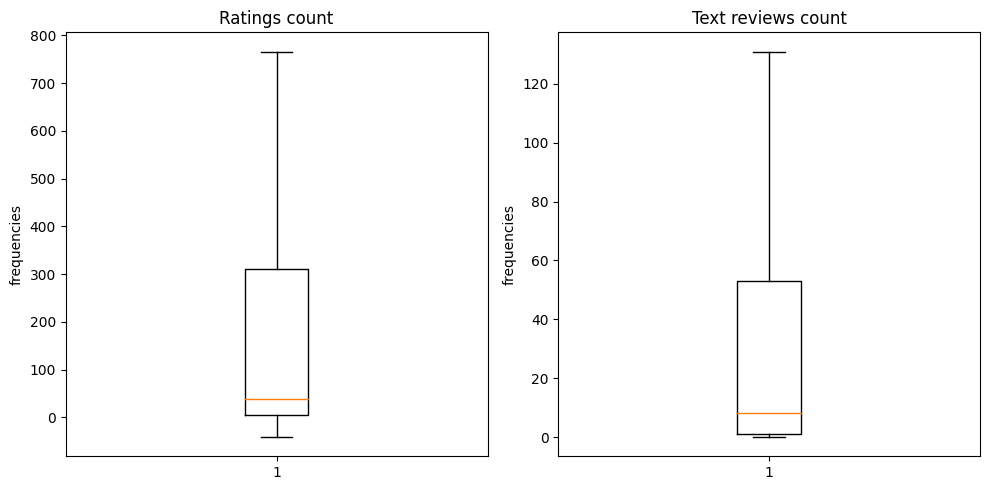

In [ ]:
#define plotting region (1 rows, 2 columns)
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

#create boxplot without outliers in each subplot
axs[0].boxplot(authors["ratings_count"], showfliers = False) #showfliers = False plots the boxplot withouth the outliers
axs[0].set_title('Ratings count')
axs[0].set_ylabel('frequencies')

axs[1].boxplot(authors["text_reviews_count"],  showfliers = False)
axs[1].set_title('Text reviews count')
axs[1].set_ylabel('frequencies')

# Show the plot
plt.tight_layout()
plt.show()


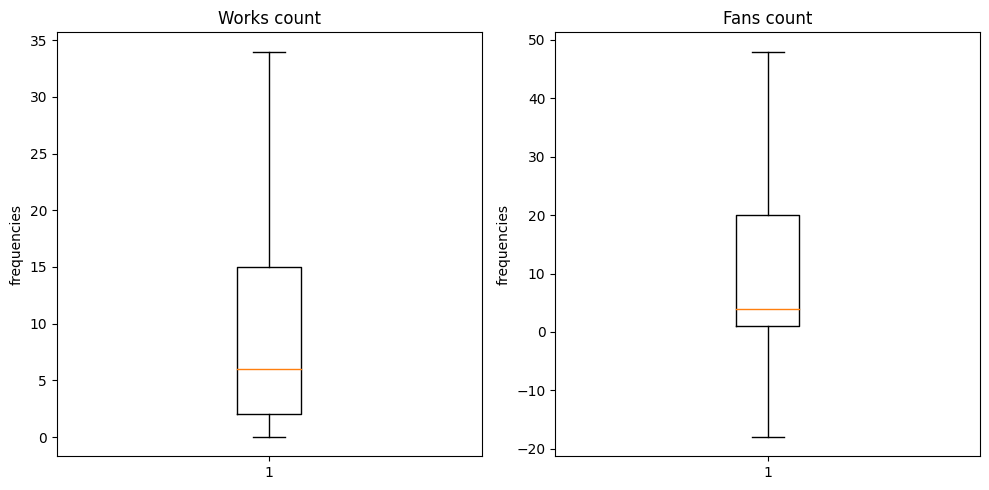

In [ ]:
#define plotting region (1 rows, 2 columns)
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

#create boxplot without outliers in each subplot
axs[0].boxplot(authors["works_count"], showfliers = False)
axs[0].set_title('Works count')
axs[0].set_ylabel('frequencies')

axs[1].boxplot(authors["fans_count"],  showfliers = False)
axs[1].set_title('Fans count')
axs[1].set_ylabel('frequencies')

# Show the plot
plt.tight_layout()
plt.show()

> From this boxplot we can see that there is a positive skewness in all the boxplot, really evident in the first 3 ones (therefore excluding the Fans count one). <br>
By looking at this representation can make the same deductions we made by looking at the statistical summaries in the table above:
* We have an unsual negative min for "ratings_count", "average_rating" and "fans_count".
* The difference between the 75% quartile and the maximum suggets the presence of outliers in the distributions, for which we can try and compute the kurtosis.


Let's compute the Kurtosis for the distributions above:

In [ ]:
from scipy.stats import kurtosis

#Kurtosis for ratings count
kurt_rc = kurtosis(authors["ratings_count"], fisher=False, bias=False) #with Fisher = True it uses Fisher approximation which normalises the kurtosis to 0
#and bias = False corrects for statistical biases

#Kurtosis for text reviews count
kurt_trc = kurtosis(authors["text_reviews_count"], fisher=False, bias=False)

#Kurtosis for works count
kurt_wc = kurtosis(authors["works_count"], fisher=False, bias=False)

#Kurtosis for fans count
kurt_fc = kurtosis(authors["fans_count"], fisher=False, bias=False)

#For a more neat output let's create a dataframe with pandas:
df_kurtosis = pd.DataFrame({
    'Column': ['ratings_count', 'text_reviews_count', 'works_count', 'fans_count'],
    'Kurtosis': [kurt_rc, kurt_trc, kurt_wc, kurt_fc]
})

print(df_kurtosis)

               Column       Kurtosis
0       ratings_count   23303.048215
1  text_reviews_count    6153.238083
2         works_count  319561.093364
3          fans_count   28305.159411


|index|Colum|Kurtosis|
|---|---|---|
|0|       ratings_count|   23303.048215|
|1|  text_reviews_count|    6153.238083|
|2|         works_count|  319561.093364|
|3|          fans_count|   28305.159411|

> From the kurtosis table we can see that the distributions that has the higher value is the works_count (kurtosis = 319561.093364), while the distribution with the lowest kurtosis is the text reviews count (kurtosis = 6153.238083). This confirms what we saw with the summary statistics: all the distribution that were taken into account have outliers, and among them the one with the highest number of outliers is the works count.

> These kurtosis values are really high, so the columns are not suitable for statistical analysis being performed.
If we want to perform some sort of statistical analysis we need to clean the data.

We can also use other visualization tools to explore some of the distribution of the columns with values that are both numerical and not, and also to see the relationships between some of them.

**Barplots and histograms**

> We start with the histograms and the barplots for the numerical columns. <br>
Computing histograms might be useful to actually see if, as suggested from the standard deviation values, the "ratings_count" are pretty spread out, while the "average_rating" are pretty much centered around the mean.

*Fans count*

Number of negative fans count:23
Number of negative fans count after turning them ino np.nan:0
Author that has the highest fans count:Stephen King


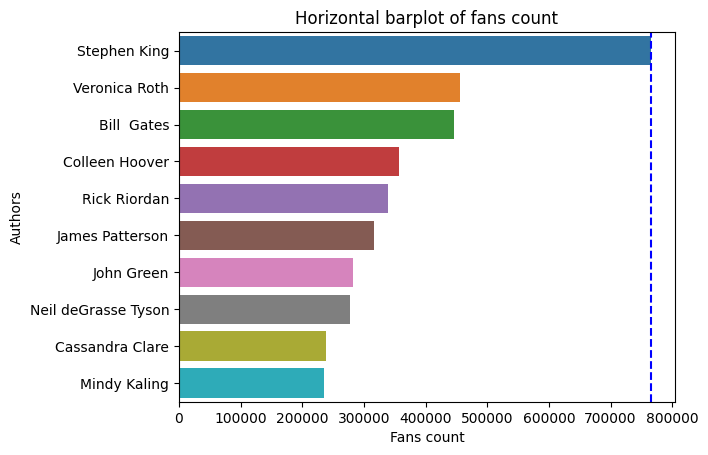

In [ ]:
#fans_count
#let's check how many negative fans count there are and, if there are any, turn them into np.nan (numpy nan values):
print("\033[1m" + "Number of negative fans count:" + "\033[0m" + str(len(authors[authors['fans_count']<0]))) # 23 negative fans count

authors['fans_count'] = authors['fans_count'].apply(lambda x : np.nan if x <= 0 else x)

print("\033[1m" + "Number of negative fans count after turning them ino np.nan:" + "\033[0m" + str(len(authors[authors['fans_count']<0]))) # 0 negative fans count
#now we don't have negative numbers and we can try to plot the histogram and see what happens:

#let's print just the top 10 authors with the highest fans count because of the computational running time:
sum_fans = authors.groupby('name')['fans_count'].sum()
top_authors = sum_fans.sort_values(ascending = False)
top_10_authors = top_authors.head(10)

authors_pd =top_10_authors.reset_index()
authors_pd.columns = ['author_name', 'fans_count']

#Let's see who, among all the authors in the dataset, has the highest fans count
#highest fan count
highest_fan_count = authors['fans_count'].max()
out = authors[authors["fans_count"] == highest_fan_count]
print("\033[1m" + "Author that has the highest fans count:" + "\033[0m" + str(out["name"].values[0])) #Stephen King (766035 fans)

sns.barplot(x = authors_pd['fans_count'], y = authors_pd['author_name'], orient = 'h')
plt.axvline(x=766035, color='blue', linestyle='--', label='Threshold') # let's add this line to the barplot


plt.xlabel('Fans count')
plt.ylabel('Authors')
plt.title('Horizontal barplot of fans count')
plt.show()

In [ ]:
#Let's see who, among all the authors in the dataset, has the lowest fans count
lowest_fan_count = authors['fans_count'].min()
out = authors[authors["fans_count"] == lowest_fan_count]
print("\033[1m" + "Authors that have the lowest fans count:" + "\033[0m" + str(out["name"].values[0])) #we print just the first one because they are too many
print("\033[1m" + "Fans count:" + "\033[0m" + str(out["fans_count"].values[0])) # 1 fan (we print just the first one because they are too man)
print("\033[1m" + "Number of authors that have the lowest fans count:" + "\033[0m" + str(len(out["name"]))) #43169 authors with just 1 fan

Authors that have the lowest fans count:Sophie Braimbridge
Fans count:1.0
Number of authors that have the lowest fans count:43169


> From the horizontal barplot we can see that among the top 10 authors with the highest fans count *Stephen King* is the first one, with 766035 fans, while on the other hand a lot of authors have just 1 fan (43169). <br>
The range of fans count is pretty wide, going from 1 to 766035.

*Text reviews count*

Number of negative text reviews count:0
Stephen King text reviews count:608956
J.K. Rowling text reviews count:606373


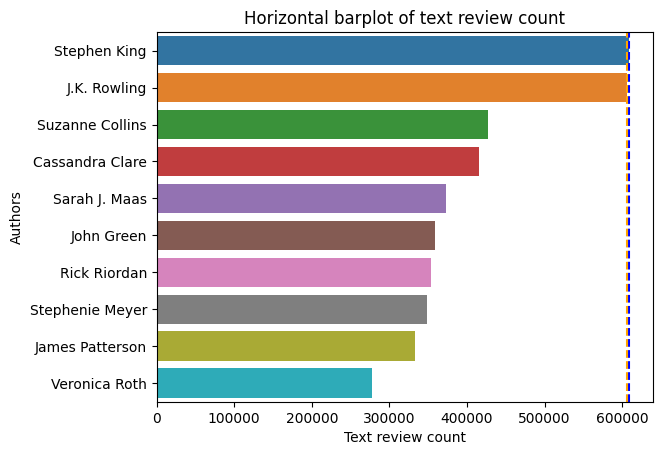

In [ ]:
#text_reviews_count
#let's check how many negative text reviews count there are and, if there are any, turn them into np.nan (numpy nan values):
print("\033[1m" + "Number of negative text reviews count:" + "\033[0m" + str(len(authors[authors['text_reviews_count'] < 0]))) #0 negative text reviews count
#We can see that we don't have negative numbers so we can try to plot the histogram and see what happens:

#let's print just the top 10 authors with the highest text reviews count because of the computational running time:
sum_fans = authors.groupby('name')['text_reviews_count'].sum()
top_authors = sum_fans.sort_values(ascending = False)
top_10_authors = top_authors.head(10)

authors_pd =top_10_authors.reset_index()
authors_pd.columns = ['author_name', 'text_reviews_count']

sns.barplot(x = authors_pd['text_reviews_count'], y = authors_pd['author_name'], orient = 'h')

#text reviews count of Stephen King
out = authors[authors["name"] == "Stephen King"]
print("\033[1m" + "Stephen King text reviews count:" + "\033[0m" + str(out["text_reviews_count"].values[0])) #608956 text reviews count

#text reviews count of J.K. Rowling
out = authors[authors["name"] == "J.K. Rowling"]
print("\033[1m" + "J.K. Rowling text reviews count:" + "\033[0m" + str(out["text_reviews_count"].values[0])) #606373 text reviews count

plt.axvline(x=608956, color='blue', linestyle='--', label='Threshold') # let's add this line to the barplot
plt.axvline(x=606373, color='orange', linestyle='--', label='Threshold') # let's add this line to the barplot

plt.xlabel('Text review count')
plt.ylabel('Authors')
plt.title('Horizontal barplot of text review count')
plt.show()

> From the plot we can see that among the top 10 authors with the highest text reviews count *Stephen King* and *J.K. Rowling* are almost at the same level with respectilvely 608956 and 606373 text reviews count. <br>
Remembering that Stephen King is among the top 10 author for the fans count and seeing that his text reviews are more or less equal to J.K. Rowling ones it could be interesting to see the latter fans count.

> So let's see the lowest text review count, and also the fans count for J.K. Rowling

In [ ]:
#lowest text review count
lowest_text_review_count = authors['text_reviews_count'].min()
out = authors[authors["text_reviews_count"] == lowest_fan_count]
print("\033[1m" + "Authors that have the lowest text reviews count:" + "\033[0m" + str(out["name"].values[0])) #we print just the first one because they are too many
print("\033[1m" + "Text reviews count:" + "\033[0m" + str(out["text_reviews_count"].values[0])) #1 text review count (we print just the first one because they are too many)
print("\033[1m" + "Number of authors that have the lowest text reviews count:" + "\033[0m" + str(len(out["name"]))) #there are multiple authors (29685) with just 1 text review count

#fan count for J.K. Rowling
out = authors[authors["name"] == "J.K. Rowling"]
print("\033[1m" + "J.K. Rowling fans count:" + "\033[0m" + str(out["fans_count"].values[0])) #213208 fans count

Authors that have the lowest text reviews count:Rob Orsini
Text reviews count:1
Number of authors that have the lowest text reviews count:29685
J.K. Rowling fans count:213208.0


> From this results we can see that there are 29685 authors who have just 1 text review count (lowest one). \\
Also the fans count of J.K. Rowling is 213208, which is much lower than Stephen King's one (766035), but still they have almost the same text review count.

*Average rating*

> Let's see if, as suggested from the standard deviation value, the "ratings_count" are pretty spread out, while the "average_rating" are pretty much centered around the mean. For that we plot an histogram for each of the distributions:

Number of negative average rating:1
Number of negative average rating after turning them into np.nan:0


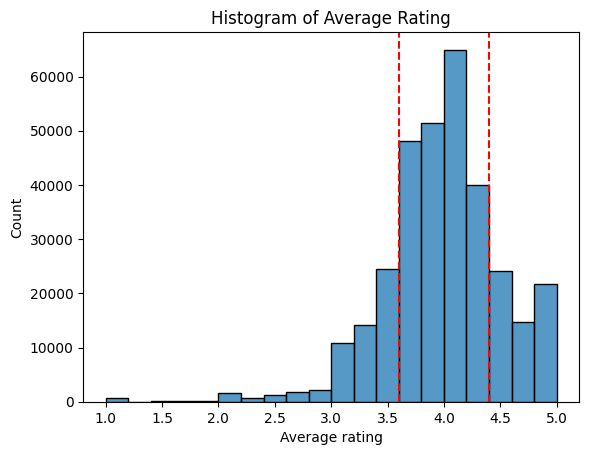

In [ ]:
#average_rating
#let's check how many negative average rating there are and, if there are any, turn them into np.nan (numpy nan values):
print("\033[1m" + "Number of negative average rating:" + "\033[0m" + str(len(authors[authors['average_rating']< 0]))) # 1 negative average rating

authors['average_rating'] = authors['average_rating'].apply(lambda x : np.nan if x <= 0 else x)
authors.dropna()

print("\033[1m" + "Number of negative average rating after turning them into np.nan:" + "\033[0m" + str(len(authors[authors['average_rating']<0]))) # 0 negative fans count
#now we don't have negative numbers and we can try to plot the histogram and see what happens:

hist = sns.histplot(authors, x="average_rating", bins = 20)
plt.axvline(x=3.60, color='red', linestyle='--', label='Threshold')
plt.axvline(x=4.40, color='red', linestyle='--', label='Threshold')

plt.xlabel('Average rating')
plt.ylabel('Count')
plt.title('Histogram of Average Rating')
plt.show()


> We can observe that the highest ratings count are concentrated between 3.60 and 4.40 (red dotted lines in the graph), it actually confirms what we saw with the statistical summary: the "average_rating" are pretty much centered around the mean. <br>
As one would expect the lowest values are the one corresponding to the ratings between to 1, 2 and 3.

*Ratings count*

> Now we can plot a density histogram withouth the outliers to have a better look at the ratings count distribution:

Number of negative ratings count:4
Number of negative ratings count after turning them into np.nan:0
mean:117.01795755622217
min:1.0
max:945.0


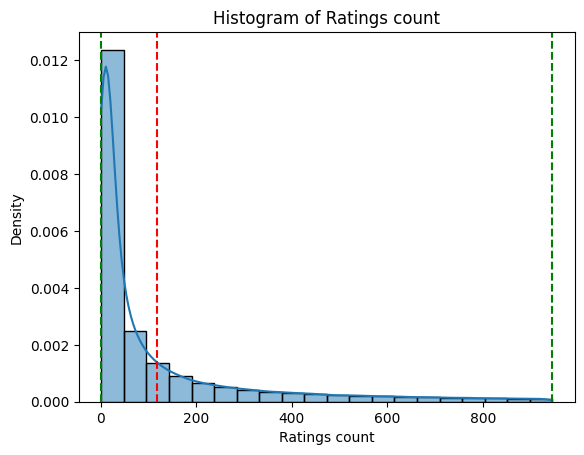

In [ ]:
#ratings_count
#let's check how many negative ratings count there are and, if there are any, turn them into np.nan (numpy nan values):
print("\033[1m" + "Number of negative ratings count:" + "\033[0m" + str(len(authors[authors['ratings_count']< 0]))) # 4 negative average rating

authors['ratings_count'] = authors['ratings_count'].apply(lambda x : np.nan if x <= 0 else x)
authors.dropna()

print("\033[1m" + "Number of negative ratings count after turning them into np.nan:" + "\033[0m" + str(len(authors[authors['ratings_count']< 0]))) # 0 negative fans count
#now we don't have negative numbers and we can try to plot the histogram and see what happens:

'''
From the statistical summary we saw that this distribution has a lot of outliers, and to plot an histogram we have to find a way to filter out those.
For example, as we said before, we can compute the IQR (interquartile range) and keep the values within that range.
'''
Q1 = authors['ratings_count'].quantile(0.25)
Q3 = authors['ratings_count'].quantile(0.75)
IQR = Q3 - Q1

authors = authors[~((authors['ratings_count'] < (Q1 - 1.5 * IQR)) | (authors['ratings_count'] > (Q3 + 1.5 * IQR)))]
ratings_count_mean = authors["ratings_count"].mean()
ratings_count_min = authors["ratings_count"].min()
ratings_count_max = authors["ratings_count"].max()

print("\033[1m" + "mean:" + "\033[0m" + str(ratings_count_mean))
print("\033[1m" + "min:" + "\033[0m" + str(ratings_count_min))
print("\033[1m" + "max:" + "\033[0m" + str(ratings_count_max))

hist = sns.histplot(authors, x="ratings_count", bins = 20, stat = "density", kde = True)

plt.axvline(x= ratings_count_mean, color='red', linestyle='--', label='Threshold')
plt.axvline(x= ratings_count_min, color='green', linestyle='--', label='Threshold')
plt.axvline(x= ratings_count_max, color='green', linestyle='--', label='Threshold')

plt.xlabel('Ratings count')
plt.ylabel('Density')
plt.title('Histogram of Ratings count')
plt.show()


> As suggested from the standard deviation of the statistical summary, this distribution is pretty spread out and not centered around the mean (117) as the average ratings one. <br>
The range of the distribution withouth the outliers goes from 1 to 945 and we can see that we have more lower ratings counts than higher ones.  

**Pieplot and Barplot**

Let's do a Pieplot to visualize the gender of the authors, and a barplot to try and see the relationship (correlation) that may exist between paired columns (for example average_rating and fans_count)

*Pieplot*

The gender counts is:
male      117026
Others     93123
female     87539
Name: gender, dtype: int64


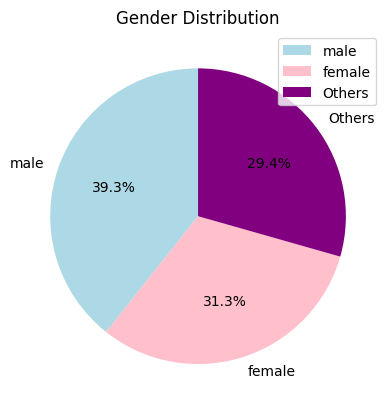

'\n#Let\'s see the percentage of male, female and "Other" genders:\nlen(authors[authors[\'gender\']== "male"]) #138179\nlen(authors[authors[\'gender\']== "female"]) #109878\nlen(authors[\'gender\']) #351767\n\nmale_perc = 138179/351767 #39.3%\nprint(male_perc)\nfemale_perc = 109878/351767 #31.2%\nprint(female_perc)\n'

In [ ]:
#To compute the Pieplot we need to count the occurences of each gender:
unique_genders = authors['gender'].unique() #to have an idea on how many genders there are

#there are a lot of other genders aside from 'male' and 'female', so let's put the other ones into "Others", and the empty strings as Nan

def gender_mapping(gender):
  if gender == "male":
    return "male"
  elif gender == "female":
    return "female"
  elif gender == "":
    return "Nan"
  else:
    return "Others"

authors["gender"] = authors["gender"].map(gender_mapping)

gender_counts = authors['gender'].value_counts() #value_counts() because to do the pieplot you need actual numbers
print("\033[1m" + "The gender counts is:\n" + "\033[0m"+ str(gender_counts))

#then let's do the pieplot on the gender
colors = sns.color_palette('pastel')
mylabels = ("male", "female", "Others")
plt.pie(gender_counts, labels = mylabels, startangle = 90, colors = ("lightblue", "pink", "purple"), autopct='%1.1f%%')
plt.title('Gender Distribution')
plt.legend()
plt.show()

'''
#Let's see the percentage of male, female and "Other" genders:
len(authors[authors['gender']== "male"]) #138179
len(authors[authors['gender']== "female"]) #109878
len(authors['gender']) #351767

male_perc = 138179/351767 #39.3%
print(male_perc)
female_perc = 109878/351767 #31.3%
print(female_perc)
'''

*Barplot for correlation visualization*

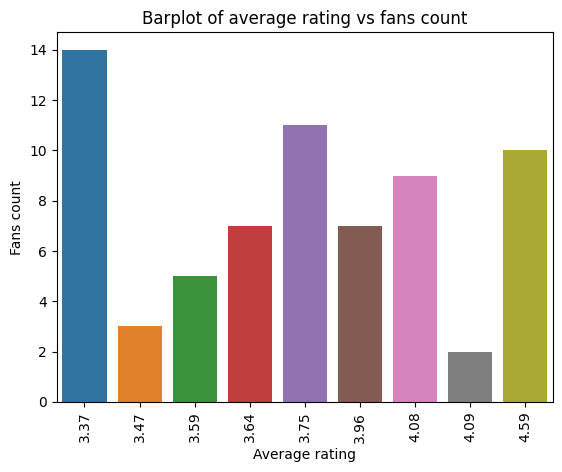

In [ ]:
#Because of the computational running time we will print the barplot of the first 10 average ratings vs fans count

#To deal with outliers in the distribution we filter them out based-off the IQR (interquartile range)
Q1 = authors['fans_count'].quantile(0.25)
Q3 = authors['fans_count'].quantile(0.75)
IQR = Q3 - Q1

authors = authors[~((authors['fans_count'] < (Q1 - 1.5 * IQR)) | (authors['fans_count'] > (Q3 + 1.5 * IQR)))]

_10_avg_rating = authors["average_rating"].head(10)
plt.xticks(rotation=90) #to avoid overlapping x-axis values
sns.barplot(authors, x = _10_avg_rating, y='fans_count')


plt.xlabel('Average rating')
plt.ylabel('Fans count')
plt.title('Barplot of average rating vs fans count')
plt.show()

> From this barplot we can see that there is a non-linear relationship between average rating and fans count, since for example the average ratings of 3.87 or 4.09 have a fans count lower than the 3.75 one.

## Retrieving the books dataset

Since it's a very big dataset and it's not convenient to import it all directly into a PanDas dataframe we used chunks (the number of books is almost 7 millions).


We set the chunksize to 10000 because it boosts the computational time.

In [ ]:
# iterating every chunk and processing it
#for chk in chunks:
  # do what you have to do


# if you want to obtain only one chunk then the only thing you have to do is using 'break'
#for chk in chunks:
  # do what you have to do with the first chunk
  #break

In [ ]:
chunks = pd.read_json(filepath_books, lines = True, chunksize = 10000)

Let's see how out dataset for books looks like:

In [ ]:
for chunk in chunks:
    pd.set_option('display.max_columns', None)
    print(chunk.head())
    break


   id                                              title  \
0   2  Harry Potter and the Order of the Phoenix (Har...   
1   3  Harry Potter and the Sorcerer's Stone (Harry P...   
2   4  Harry Potter and the Chamber of Secrets (Harry...   
3   5  Harry Potter and the Prisoner of Azkaban (Harr...   
4   6  Harry Potter and the Goblet of Fire (Harry Pot...   

                                             authors   author_name  author_id  \
0  [{'id': '1077326', 'name': 'J.K. Rowling', 'ro...  J.K. Rowling    1077326   
1  [{'id': '1077326', 'name': 'J.K. Rowling', 'ro...  J.K. Rowling    1077326   
2                                               None  J.K. Rowling    1077326   
3  [{'id': '1077326', 'name': 'J.K. Rowling', 'ro...  J.K. Rowling    1077326   
4  [{'id': '1077326', 'name': 'J.K. Rowling', 'ro...  J.K. Rowling    1077326   

   work_id        isbn         isbn13 asin language  average_rating  \
0  2809203  0439358078  9780439358071           eng            4.50   
1  4640799

Let's check for Nan values with the same function we used for the authors dataset:

In [ ]:
#check for Nan
chunks = pd.read_json(filepath_books, lines = True, chunksize = 10000)
counter = 0
for chunk in chunks:
  empty_string = np.where(chunk.isna())
  counter += len(empty_string[0])
print("\033[1m" + "Number of NaN values in the books dataset:" + "\033[0m" + str(counter)) #5358715 Nan

Number of NaN values in the books dataset:5358715


> Since this books dataset was divided it into chunks by rows, to get the overall shape we need to write a function that sums up all them. For the columns name we just need one of the chunks.

> After getting the overall shape of the dataframe we can check the percentage of Nan values and see whether it's relevant or not.

In [ ]:
#dataframe shape
chunks = pd.read_json(filepath_books, lines = True, chunksize = 10000)
num_rows = 0
for chunk in chunks:
  rows = chunk.shape[0]
  num_rows += rows
  column_num = chunk.shape[1]
print("\033[1m" + "Number of rows:" + "\033[0m" + str(num_rows),"\033[1m")
print("Number of columns:" + "\033[0m" + str (column_num)) #7017432 rows and 26 column

Number of rows:7027431 
Number of columns:26


In [ ]:
#Let's see the percentage of the Nan in the dataset
empty_perc = (5358715/(7027431*26))*100
print("\033[1m" + "% of NaN values in the books dataset:" + "\033[0m" + str(empty_perc)) #2.93%

'''
The NaN values are just the 2.93% in the whole dataset so they're negligible.
'''

% of NaN values in the books dataset:2.932855876876245


"\nThe NaN values are just the 2.93% in the whole dataset so they're negligible.\n"

## Dataset overview and statistical summary
From the previuos point we have already seen that the dataframe is 7017432 rows by 26 columns, now let's see the datatypes and the summary statistics:

In [ ]:
#Let's see what datatypes we have in the dataset:
chunks = pd.read_json(filepath_books, lines = True, chunksize = 10000)
for chunk in chunks:
  datatype = chunk.dtypes
  print("\033[1m" + "The datatypes in the dataset are:" + "\033[0m\n" + str(datatype))
  break

The datatypes in the dataset are:
id                             int64
title                         object
authors                       object
author_name                   object
author_id                      int64
work_id                        int64
isbn                          object
isbn13                        object
asin                          object
language                      object
average_rating               float64
rating_dist                   object
ratings_count                  int64
text_reviews_count             int64
publication_date              object
original_publication_date     object
format                        object
edition_information           object
image_url                     object
publisher                     object
num_pages                     object
series_id                     object
series_name                   object
series_position               object
shelves                       object
description                   object
dtyp

> From this description we can see that we have a lot of "object" datatypes

In [ ]:
#Let's see the summary statistics for the dataset
chunks = pd.read_json(filepath_books, lines = True, chunksize = 10000)

whole_df = pd.DataFrame()
for chunk in chunks:
  chunk_description=chunk.describe() #describe chunks
  whole_df=pd.concat([whole_df, chunk_description]) #concatenate the chunks description together into a dataframe
  description = whole_df.describe() #describe() on the whole dataframe
print("\033[1m" + "The dataset summary statistics are:" + "\033[0m\n" + str(description))

The dataset summary statistics are:
                 id     author_id       work_id  average_rating  \
count  5.624000e+03  5.624000e+03  5.624000e+03     5624.000000   
mean   9.953850e+06  3.729290e+06  1.922276e+07     1252.096045   
std    8.759659e+06  6.700446e+06  2.792541e+07     3305.321919   
min    2.000000e+00  4.000000e+00  6.200000e+01        0.000000   
25%    2.786025e+04  9.999000e+03  3.627644e+04        1.647087   
50%    9.439664e+06  7.404532e+05  8.853076e+06        3.690000   
75%    1.808625e+07  3.195924e+06  2.127865e+07        4.422500   
max    2.552102e+07  2.124802e+07  8.972161e+07     9999.000000   

       ratings_count  text_reviews_count  
count   5.624000e+03         5624.000000  
mean    6.787911e+05        17233.633517  
std     1.821208e+06        42209.195171  
min     0.000000e+00            0.000000  
25%     1.100000e+01            1.000000  
50%     3.461743e+03          195.000000  
75%     4.378927e+04         7792.183940  
max     7.400639

> From the statistical summary, in particular from the difference between the 75% quartile and the maximum value of the distribution, we can see that the average_ratings, text_reviews_count and rating_count have a significant number of outliers.

> id, author_id, work_id, ratings_count and text_reviews_count columns have a large number of unique values (count), with the mean and standard deviation also indicating a wide spread of values. <br>
The average rating is around 1252, and the standard deviation is around 3305.
This means that the ratings are spread out, with many works having a rating close to the average and a few works having very high or low ratings.

> The standard deviation suggests that the text_reviews_count (std = 42209.195171) and the average_ratings (std = 42209.195171) distributions have values that are spread out while, for example, the ratings_count (std = 1.821208e+06) has values more centered around the mean.


## Visualization tools

We can now provide a visual representation of the distributions that have significant outliers and some of the other columns of the dataset.

**Boxplots**

*Boxplot with the outliers*
> With the boxplot we represent the average_ratings, text_reviews_count and rating_count distribution keeping the outliers:

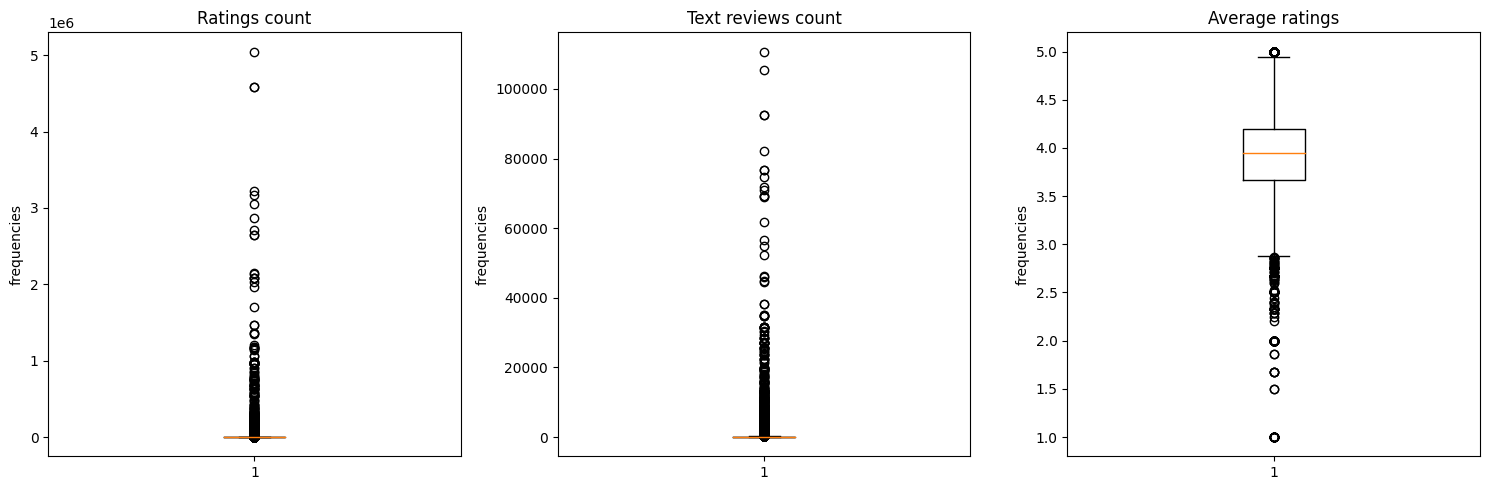

In [ ]:
#Let's clean a bit the data first
chunks = pd.read_json(filepath_books, lines = True, chunksize = 10000)

for chunk in chunks:
  chunk["average_rating"].replace('', np.NaN, inplace = True)
  chunk["average_rating"].replace(0.00, np.NaN, inplace = True)
  chunk["text_reviews_count"].replace('', np.NaN, inplace = True)
  chunk["ratings_count"].replace('', np.NaN, inplace = True)

  chunk = chunk[~chunk["average_rating"].isna()]
  chunk = chunk[~chunk["text_reviews_count"].isna()]
  chunk = chunk[~chunk["ratings_count"].isna()]

  ch = chunk[["text_reviews_count","average_rating", "ratings_count"]]


#define plotting region (1 rows, 3 columns)
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

#create boxplot without outliers in each subplot
axs[0].boxplot(chunk["ratings_count"])
axs[0].set_title('Ratings count')
axs[0].set_ylabel('frequencies')

axs[1].boxplot(chunk["text_reviews_count"])
axs[1].set_title('Text reviews count')
axs[1].set_ylabel('frequencies')

axs[2].boxplot(chunk["average_rating"])
axs[2].set_title('Average ratings')
axs[2].set_ylabel('frequencies')

# Show the plot
plt.tight_layout()
plt.show()

*Boxplot without the outliers*
> From the boxplots above we can see that among the 3 representations the Average ratings is the distribution that has less outliers, the other two have so many outliers that we can't even see the box. <br>
In order to actually see the distributions we represent the boxplot without showing the ouliers, with the option showfliers = False:

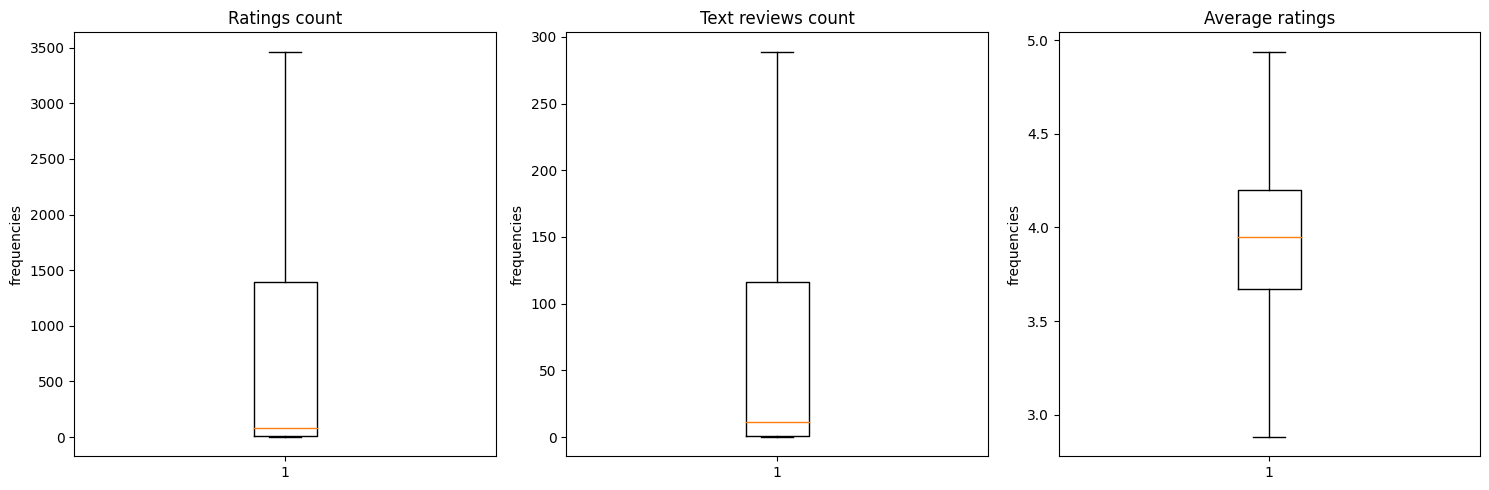

In [ ]:
chunks = pd.read_json(filepath_books, lines = True, chunksize = 10000)

for chunk in chunks:
  chunk["average_rating"].replace('', np.NaN, inplace = True)
  chunk["average_rating"].replace(0.00, np.NaN, inplace = True)
  chunk["text_reviews_count"].replace('', np.NaN, inplace = True)
  chunk["ratings_count"].replace('', np.NaN, inplace = True)

  chunk = chunk[~chunk["average_rating"].isna()]
  chunk = chunk[~chunk["text_reviews_count"].isna()]
  chunk = chunk[~chunk["ratings_count"].isna()]

  ch = chunk[["text_reviews_count","average_rating", "ratings_count"]]

#define plotting region (1 rows, 3 columns)
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

#create boxplot without outliers in each subplot
axs[0].boxplot(chunk["ratings_count"], showfliers = False)
axs[0].set_title('Ratings count')
axs[0].set_ylabel('frequencies')

axs[1].boxplot(chunk["text_reviews_count"], showfliers = False)
axs[1].set_title('Text reviews count')
axs[1].set_ylabel('frequencies')

axs[2].boxplot(chunk["average_rating"], showfliers = False)
axs[2].set_title('Average ratings')
axs[2].set_ylabel('frequencies')

# Show the plot
plt.tight_layout()
plt.show()

> We can see that there is an evident positive skeweness in the ratings_count and text_reviews_count distribution, while the average_rating distribution seems to have no skeweness. All the distributions have positive values. <br>
The ratings_count and text_reviews_count have a wider range of values than the average_rating for obivous reasons.

> From the quartiles we can also say that, while the average ratings probabily has a bell-like distribution, the ratings count and the text reviews count have the majority of their observations concentrated towards the lower values.

**Histogram**

> We can try and plot the histograms for the average_ratings, text_reviews_count and rating_count columns and compare them to the boxplot made above to have a better insight on their distribution.

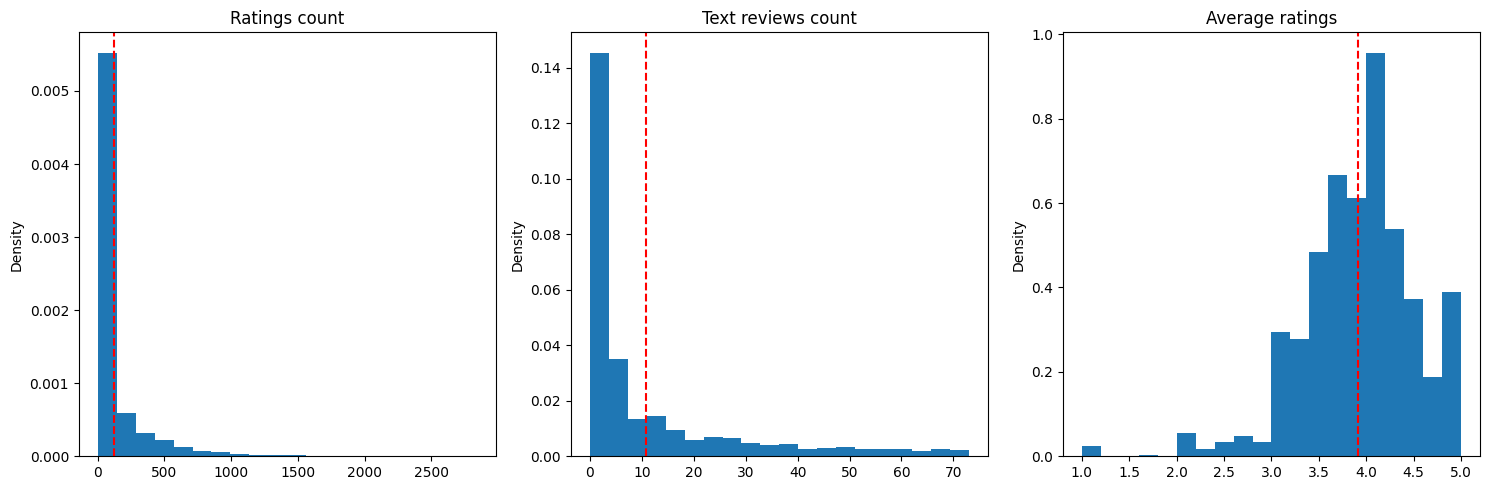

In [ ]:
chunks = pd.read_json(filepath_books, lines = True, chunksize = 10000)

for chunk in chunks:
  chunk["average_rating"].replace('', np.NaN, inplace = True)
  chunk["average_rating"].replace(0.00, np.NaN, inplace = True)
  chunk["text_reviews_count"].replace('', np.NaN, inplace = True)
  chunk["ratings_count"].replace('', np.NaN, inplace = True)

  chunk = chunk[~chunk["average_rating"].isna()]
  chunk = chunk[~chunk["text_reviews_count"].isna()]
  chunk = chunk[~chunk["ratings_count"].isna()]

  #To filter out outliers values
  Q1 = chunk['ratings_count'].quantile(0.25)
  Q3 = chunk['ratings_count'].quantile(0.75)
  IQR = Q3 - Q1

  chunk = chunk[~((chunk['ratings_count'] < (Q1 - 1.5 * IQR)) | (chunk['ratings_count'] > (Q3 + 1.5 * IQR)))]

  Q_1 = chunk['text_reviews_count'].quantile(0.25)
  Q_3 = chunk['text_reviews_count'].quantile(0.75)
  IQR_ = Q_3 - Q_1

  chunk = chunk[~((chunk['text_reviews_count'] < (Q_1 - 1.5 * IQR_)) | (chunk['text_reviews_count'] > (Q_3 + 1.5 * IQR_)))]

  ch = chunk[["text_reviews_count","average_rating", "ratings_count"]]

ratings_count_mean = ch["ratings_count"].mean()
text_reviews_count_mean = ch["text_reviews_count"].mean()
average_rating_mean = ch["average_rating"].mean()

#Define plotting region
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

#create density histograms in each subplot
axs[0].hist(chunk["ratings_count"], bins=20, density = True)
axs[0].axvline(x =ratings_count_mean, color='red', linestyle='--')
axs[0].set_title('Ratings count')
axs[0].set_ylabel('Density')

axs[1].hist(chunk["text_reviews_count"], bins=20, density = True)
axs[1].axvline(x=text_reviews_count_mean, color='red', linestyle='--')
axs[1].set_title('Text reviews count')
axs[1].set_ylabel('Density')

axs[2].hist(chunk["average_rating"], bins=20, density = True)
axs[2].axvline(x=average_rating_mean, color='red', linestyle='--')
axs[2].set_title('Average ratings')
axs[2].set_ylabel('Density')

# Show the plot
plt.tight_layout()
plt.show()


> The positive skeweness we found by looking at the boxplot also appears in the histogram plot. <br>
We can also see that the major of the observations for the ratings count and the text reviews count distributions are towards the lower values, obiviously not centered around the mean. <br>
The average ratings distribution has a bell shape centered around the mean.


**Barplot**

> We can also try a barplot for the languages column:

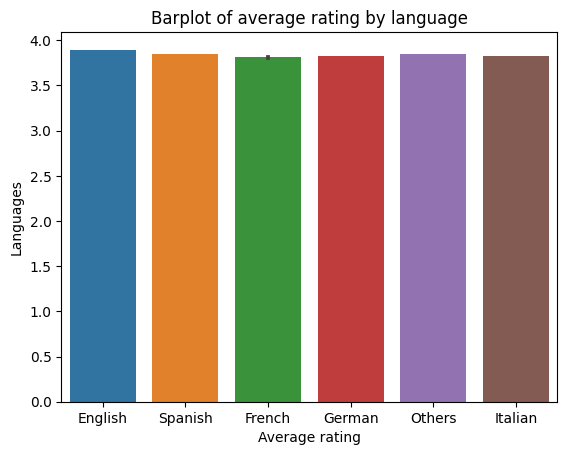

In [ ]:
#Let's clean the language first:
chunks = pd.read_json(filepath_books, lines = True, chunksize = 10000)

def language_translate(language):
  if language == "English" or language == "eng" or language == "en" or language == "en-US" or language == "en-GB" or language == "en-CA" or language == "en-IN":
    return "English"
  elif language == "ger":
    return "German"
  elif language == "ita":
    return "Italian"
  elif language == "spa":
    return "Spanish"
  elif language == "fre":
    return "French"
  elif language == '':
    return np.NaN
  else:
    return "Others"

chunks = pd.read_json(filepath_books, lines = True, chunksize = 10000)

language_df = pd.DataFrame()
for chunk in chunks:
  chunk["language"] = chunk["language"].astype(str)
  chunk["language"] = chunk["language"].map(language_translate)
  chunk["average_rating"].replace('', np.NaN, inplace = True)
  chunk["average_rating"].replace(0.00, np.NaN, inplace = True)

  chunk = chunk[~chunk["language"].isna()]
  chunk = chunk[~chunk["average_rating"].isna()]
  language_df = pd.concat([language_df, chunk[["language", "average_rating"]]])

sns.barplot(x = language_df['language'], y = language_df['average_rating'])

plt.xlabel('Average rating')
plt.ylabel('Languages')
plt.title('Barplot of average rating by language')
plt.show()

> We can see that the average rating it's actually almost the same in all the languages represented, with minimal differences.

---
# [RQ2]

In [ ]:
dataset_authors = pd.read_json(filepath_authors, lines=True)
chunks = pd.read_json(filepath_books, lines = True, chunksize = 10000)

### RQ2-1. *Plot the number of books for each author in descending order.*

In [ ]:
df1 = dataset_authors[['book_ids', 'name']].copy()
df1['book_ids'] = df1['book_ids'].apply(lambda x: list(set(x))).str.len()
df1.sort_values(by='book_ids', ascending=False, inplace=True)
df1.rename(columns={"book_ids": "number_of_books"}, inplace=True)
df1

,number_of_books,name
7646,1530,Chuck Dixon
3114,1530,Stan Lee
23792,1530,Agatha Christie
4760,1530,Isaac Asimov
3201,1530,Enid Blyton
...,...,...
225259,1,James D. Roumeliotis
351766,1,James Ross
123922,0,Kamryn Hart
57720,0,L. Adams Beck


### RQ2-2. *Which book has the highest number of reviews?*

We observed that the book with highest number of reviews has two versions,   
therefore when we print the books with maximal revies we got the same book twice.

In [ ]:
chunks = pd.read_json(filepath_books, lines = True, chunksize = 10000)

max_rating = 0
df2 = pd.DataFrame()

for chunk in chunks:
    df_review = chunk[['title', 'ratings_count']].copy()
    max_rating_in_chunk = df_review['ratings_count'].max()
    if max_rating_in_chunk > max_rating:
        max_rating = max_rating_in_chunk
        df2 = df_review.loc[df_review['ratings_count'] == max_rating]
    if max_rating_in_chunk == max_rating:
        new_row = df_review.loc[df_review['ratings_count'] == max_rating]
        df2 = df2.append(new_row, ignore_index=True)

print(df2)

                                               title  ratings_count
0  Harry Potter und der Stein der Weisen (Harry P...        7400639
1  Harry Potter und der Stein der Weisen (Harry P...        7400639


### RQ2-3. *Which are the top ten and ten worst books concerning the average score?*

We noticed that there are many books with the highest score - 5 and the lowest score - 0 (much more than 10),   
Therefore, since we only asked to provide 10 books in each category,   
we decided to take the 10 that also have the **highest amout of reviews.**   

Hence from each chunk we take the 10 books with highest score.  
If there are more than 10 with same highest score we take all books by using:  
df1.nlargest(10, 'average_rating', keep='all')  
after we took the highest 10 from each chunk, we take the 10 books with highest number of reviews by using:  
df1.nlargest(10, 'average_rating', keep='first')  

In [ ]:
chunks = pd.read_json(filepath_books, lines = True, chunksize = 10000)

top_average_score = []
worst_average_score = []

for chunk in chunks:
    df3 = chunk[['title', 'average_rating', 'ratings_count']].copy()
    top_average_score.append(df3.nlargest(10, 'average_rating', keep='all'))
    worst_average_score.append(df3.nsmallest(10, 'average_rating', keep='all'))
    
top_average_score = pd.concat(top_average_score)
worst_average_score = pd.concat(worst_average_score)

top_average_score.sort_values(by='ratings_count', ascending=False, inplace=True)
worst_average_score.sort_values(by='ratings_count', ascending=False, inplace=True)

final_df_top = top_average_score.nlargest(10, 'average_rating', keep='first')
final_df_worst = worst_average_score.nsmallest(10, 'average_rating', keep='first')
print(final_df_top)
print(final_df_worst)

                                                     title  average_rating  \
4851446  Optimized Nutrition:: A strategic guide for th...             5.0   
5782558  Optimized Nutrition Vol. 4: Building a Bigger ...             5.0   
6133847  Optimized Nutrition Vol. 5 Building a huge big...             5.0   
6367886                         Optimized Nutrition Vol. 6             5.0   
6567263                         Optimized Nutrition Vol. 7             5.0   
6909719  Optimized Nutrition Vol. 8: Building Anabolic ...             5.0   
6408367                                               Mora             5.0   
6284623              Children's Virtues: N is for Nobility             5.0   
6111305       Children's Virtues N is for Nobility Book 14             5.0   
3463729  A Muezzin from the Tower of Darkness Cries: Tr...             5.0   

         ratings_count  
4851446            216  
5782558            211  
6133847            174  
6367886            169  
6567263         

### RQ2-4. *Explore the different languages in the book’s dataset*

After exploring the data we saw we have more than 200 different languages in our books dataset.  
We decided to show how these languages are distributed according to the top 5 languages in the dataset.  
After finding those top 5 languages we had to convert the names of all languages,  
since English for example has 5 different names which all stand for it.  
In our chart we also plot 'NaN'- which stand for books that has no language value
and 'Other' which stand for all other languages in our dataset.

+----+------------+-------------+
|    | language   |   books_num |
|----+------------+-------------|
|  4 | Nan        |     4340264 |
|  0 | English    |     1531826 |
|  5 | Other      |      623613 |
|  2 | German     |      148087 |
|  6 | Spanish    |      137292 |
|  3 | Italian    |      125287 |
|  1 | French     |      121062 |
+----+------------+-------------+


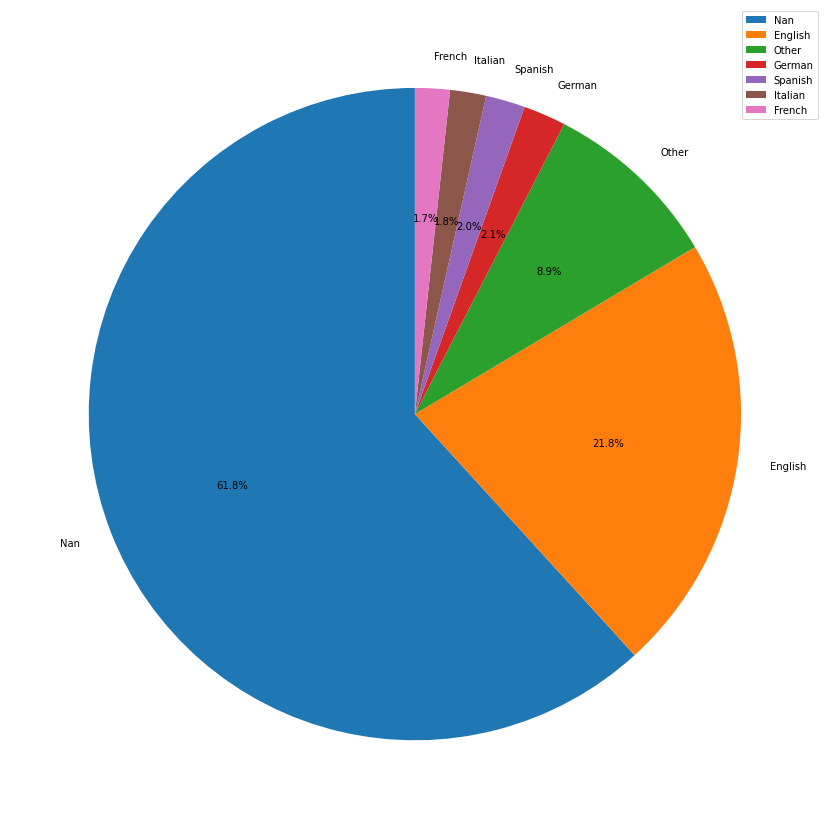

In [ ]:
def language_translate(language):
    if language == 'English' or language == 'eng' or language == 'en' or language == 'en-US' or language == 'en-GB' or language == 'en-CA' or language == 'en-IN':
        return 'English'
    elif language == 'ger':
        return 'German'
    elif language == 'spa':
        return 'Spanish'
    elif language == 'ita':
        return 'Italian'
    elif language == 'fre':
        return 'French'
    elif language == '':
        return 'Nan'
    else:
        return 'Other'


chunks = pd.read_json(filepath_books, lines = True, chunksize = 10000)
final_df = pd.DataFrame()

for chunk in chunks:
    df4 = chunk[['language']].copy()
    df4['language'] = df4['language'].astype(str)
    df4['language'] = df4['language'].map(language_translate)
    grouped = df4.groupby('language').size().reset_index(name='count')
    final_df = final_df.append(grouped)
    
grouped1 = final_df.groupby('language')['count'].sum().reset_index(name='books_num')
final_df = grouped1
final_df.sort_values(by='books_num', ascending=False, inplace=True)
print(tabulate(final_df, headers="keys", tablefmt="psql"))

plt.figure(figsize=(15, 15))
y = np.array(final_df['books_num'])
mylabels = list(final_df['language'])

plt.pie(y, labels = mylabels, startangle = 90, autopct='%1.1f%%')
plt.legend()
plt.show() 

### RQ2-5. *How many books have more than 250 pages?*

In [ ]:
chunks = pd.read_json(filepath_books, lines = True, chunksize = 10000)

count = 0
for chunk in chunks:
    df5 = chunk[['num_pages']].copy()
    df5['num_pages'] = pd.to_numeric(df5['num_pages'], errors='coerce')
    count += df5[df5['num_pages'] > 250].shape[0]

print(count)

1810335


### RQ2-6. *Plot the distribution of the fans count for the 50 most prolific authors*

We presented the distribution according to the groups that seemed most significant to us.

We chose to divide the autors into the following groups:
1. Authors with less than 100 fans
2. Authors with less than 500 fans and more than 100
3. Authors with less than 1000 fans and more than 500
4. Authors with less than 5000 fans and more than 1000
5. Authors with less than 10000 fans and more than 20000
6. Authors with less than 100000 fans and more than 20000
7. Authors with less than 1000000 fans and more than 100000

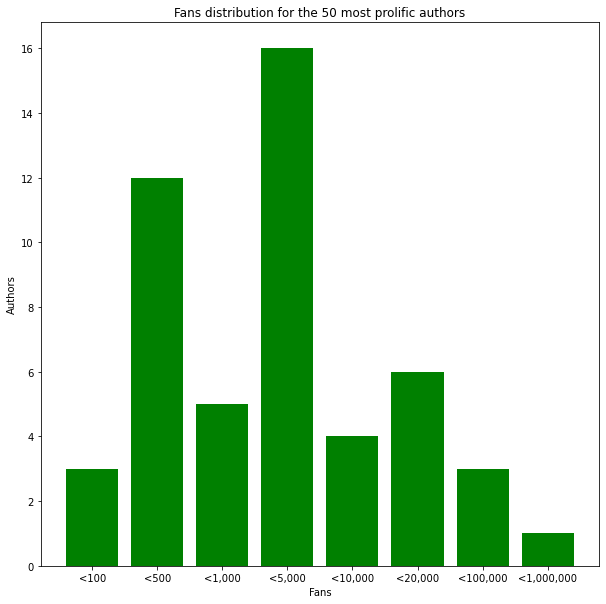

In [ ]:
import matplotlib.pyplot as plt

def calc_pos(value: int) -> int:
    if value <= 100:
        return 0
    if value > 100 and value <= 500:
        return 1
    if value > 500 and value <= 1000:
        return 2
    if value > 1000 and value <= 5000:
        return 3
    if value > 5000 and value <= 10000:
        return 4
    if value > 10000 and value <= 20000:
        return 5
    if value > 20000 and value <= 100000:
        return 6
    if value > 100000 and value <= 1000000:
        return 7
    
hist = np.zeros(8)   
df6 = dataset_authors[['book_ids', 'fans_count']].copy()
df6.loc[:, 'book_ids'] = df6['book_ids'].str.len()
df6.sort_values(by='book_ids', ascending=False, inplace=True)
df6 = df6.head(50)
data = df6['fans_count']
for i in data:
    hist[calc_pos(i)] += 1


# x-coordinates of left sides of bars  
left = [1, 2, 3, 4, 5, 6, 7, 8] 

# labels for bars 
tick_label = ['<100', '<500', '<1,000', '<5,000', '<10,000', '<20,000', '<100,000', '<1,000,000'] 
  
# plotting a bar chart
plt.figure(figsize=(10, 10))
plt.bar(left, hist, tick_label = tick_label, 
        width = 0.8, color = ['green']) 
  
# naming the x-axis 
plt.xlabel('Fans') 
# naming the y-axis 
plt.ylabel('Authors') 
# plot title 
plt.title('Fans distribution for the 50 most prolific authors') 
# function to show the plot 
plt.show() 

---
# [RQ3]

We realize that to construct a new data frame with year as primary key and the required information as attributes
will take a very long running time if we have to run over the whole dataset for each year.   
Therefore we decided to create a dictionary that contains year as key and the required attributes as value.   
That way our function only take the values from the dictionary.  
To create the dictionary we run over the data base only once.
Before we started working on the question we realized that we needed to organize all the column types,   
and especially the type of 'publication_date' and 'num_pages'.  
We had to handel with:  
- missing dates- with empty value in 'publication_date'  
- dates that are not valid- like year '3001'  
- dates that are not complete- as '2001-01'

In [ ]:
## First we create a dictionary that contains year as key and the required attributes as value. 
def num_pages_fix(num):
    if num <= 0:
        return None
    else:
        return num 

def year_fix(year):
    if year > 2023:
        return 'Invalid'
    else:
        return year
    
chunks = pd.read_json(filepath_books, lines = True, chunksize = 10000)
result = {}
for chunk in chunks:
        df = chunk[['title', 'publication_date', 'num_pages']].copy()
        df['publication_date'] = pd.to_datetime(df['publication_date'], errors='coerce')
        df['num_pages'] = pd.to_numeric(df['num_pages'], errors='coerce')
        df['num_pages'] = df['num_pages'].map(num_pages_fix)
        df_h = df[df['publication_date'].notnull() & df['num_pages'].notnull()]
        
        df_h['year'] = df_h['publication_date'].dt.year
        df_h['year'] = df_h['year'].map(year_fix)
        df_h['month'] = df_h['publication_date'].dt.month
        grouped = df_h.groupby('year')
        for year, group in grouped:
            total_books = len(group)
            
            total_pages = group['num_pages'].sum()
            
            monthly_counts = group.groupby('month').size()
            most_prolific_month = monthly_counts.idxmax()
        
            longest_book = group[group['num_pages'] == group['num_pages'].max()]
            longest_book_num_pages = group['num_pages'].max()
            
            if year in result:
                result[year]['total_books'] += total_books
                result[year]['total_pages'] += total_pages
                
                merged_counts = monthly_counts.add(result[year]['monthly_counts'], fill_value=0)
                most_prolific_month = merged_counts.idxmax()
                result[year]['most_prolific_month'] = most_prolific_month
                result[year]['monthly_counts'] = merged_counts

                if result[year]['longest_book_num_pages'] < longest_book_num_pages:
                    result[year]['longest_book'] = longest_book 
                    result[year]['longest_book_num_pages'] = longest_book_num_pages
            else:
                result[year] = {'total_books': total_books, 'total_pages': total_pages, 'most_prolific_month': most_prolific_month, 'monthly_counts': monthly_counts, 'longest_book': longest_book, 'longest_book_num_pages': longest_book_num_pages}
print(result)

/var/folders/c2/t01w5t9j4ks01l3tm6pfc7rc0000gn/T/ipykernel_6731/3953507472.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_h['year'] = df_h['publication_date'].dt.year
/var/folders/c2/t01w5t9j4ks01l3tm6pfc7rc0000gn/T/ipykernel_6731/3953507472.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_h['year'] = df_h['year'].map(year_fix)
/var/folders/c2/t01w5t9j4ks01l3tm6pfc7rc0000gn/T/ipykernel_6731/3953507472.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Dat

{1888: {'total_books': 150, 'total_pages': 43941.0, 'most_prolific_month': 1, 'monthly_counts': month
1     131.0
4      11.0
5       2.0
8       1.0
9       2.0
10      2.0
12      1.0
dtype: float64, 'longest_book':                                                      title publication_date  \
6447435  The Great Cryptogram: Francis Bacon's Cipher i...       1888-01-01   

         num_pages  year  month  
6447435      998.0  1888      1  , 'longest_book_num_pages': 998.0}, 1899: {'total_books': 333, 'total_pages': 113371.0, 'most_prolific_month': 1, 'monthly_counts': month
1     279.0
2       2.0
4       7.0
6       1.0
7       1.0
8       1.0
9       1.0
12     41.0
dtype: float64, 'longest_book':                                                      title publication_date  \
4496325  El libro de las mil y una noches: Edición comp...       1899-01-01   

         num_pages  year  month  
4496325     3613.0  1899      1  , 'longest_book_num_pages': 3613.0}, 1900: {'total_books': 2285,

### RQ3-1. Historical look at the dataset!

In [ ]:
## RQ3- Historical look at the dataset!

def year_historic(year: int):
    return result[year]['total_books'], result[year]['total_pages'], result[year]['most_prolific_month'], result[year]['longest_book']


In [ ]:
## Get a list of all relevant publication years in the data frame
def year_fix(year):
    if year > 2023:
        return None
    else:
        return year

chunks = pd.read_json(filepath_books, lines = True, chunksize = 10000)
years = []
for chunk in chunks:
    df_historic = chunk[['publication_date', 'num_pages']].copy()
    df_historic['publication_date'] = pd.to_datetime(df_historic['publication_date'], errors='coerce')
    df_historic['year'] = df_historic['publication_date'].dt.year
    df_historic['year'] = df_historic['year'].map(year_fix)
    df_historic['num_pages'] = pd.to_numeric(df_historic['num_pages'], errors='coerce')
    df_historic['num_pages'] = df_historic['num_pages'].map(num_pages_fix)
    df_historic = df_historic[df_historic['year'].notnull() & df_historic['num_pages'].notnull()]
    years.extend(df_historic['year'].unique())
print(set(years))

{1678.0, 1679.0, 1680.0, 1681.0, 1682.0, 1684.0, 1686.0, 1688.0, 1689.0, 1691.0, 1692.0, 1694.0, 1696.0, 1697.0, 1698.0, 1700.0, 1701.0, 1703.0, 1705.0, 1710.0, 1711.0, 1713.0, 1714.0, 1715.0, 1717.0, 1719.0, 1720.0, 1722.0, 1724.0, 1725.0, 1726.0, 1728.0, 1729.0, 1731.0, 1732.0, 1733.0, 1734.0, 1736.0, 1737.0, 1740.0, 1741.0, 1742.0, 1746.0, 1747.0, 1748.0, 1749.0, 1750.0, 1751.0, 1752.0, 1753.0, 1755.0, 1756.0, 1757.0, 1758.0, 1759.0, 1760.0, 1762.0, 1765.0, 1766.0, 1767.0, 1768.0, 1769.0, 1771.0, 1773.0, 1774.0, 1775.0, 1776.0, 1778.0, 1779.0, 1780.0, 1781.0, 1782.0, 1783.0, 1784.0, 1785.0, 1786.0, 1787.0, 1788.0, 1789.0, 1790.0, 1791.0, 1792.0, 1793.0, 1794.0, 1795.0, 1796.0, 1797.0, 1798.0, 1799.0, 1800.0, 1801.0, 1802.0, 1803.0, 1804.0, 1805.0, 1806.0, 1807.0, 1808.0, 1809.0, 1810.0, 1811.0, 1812.0, 1813.0, 1814.0, 1815.0, 1816.0, 1817.0, 1818.0, 1819.0, 1820.0, 1821.0, 1822.0, 1823.0, 1824.0, 1825.0, 1826.0, 1827.0, 1828.0, 1829.0, 1830.0, 1831.0, 1832.0, 1833.0, 1834.0, 1835.0,

### RQ3-2. Use this function to build your data frame

In [ ]:
## Use my function to build the data frame

df_year = pd.DataFrame(columns=['year','total_books', 'total_pages', 'most_prolific_month', 'longest_book'])
for i in set(years):
    year = int(i)
    total_books, total_pages, most_prolific_month, longest_book = year_historic(int(i))
    df_year = df_year.append({'year': int(i), 'total_books': total_books , 'total_pages': total_pages, 'most_prolific_month': most_prolific_month, 'longest_book': longest_book}, ignore_index=True)
print(df_year.head(10))
print(df_year.tail(10))

   year total_books  total_pages most_prolific_month  \
0  1678           1        257.0                   1   
1  1679           2        958.0                   1   
2  1680           1        182.0                   1   
3  1681           1        297.0                   1   
4  1682           2        132.0                   1   
5  1684           3        658.0                   1   
6  1686           4       1472.0                   1   
7  1688           2        112.0                   1   
8  1689           1         63.0                   1   
9  1691           2        429.0                   1   

                                        longest_book  
0                                 title publicati...  
1               title publication_date  num_pages...  
2                                                ...  
3                 title publication_date  num_pag...  
4                                                ...  
5                                                ... 

### RQ3-3. Ask ChatGPT or any other LLM chatbot tool to implement this function and compare your work

The following is LLM code suggested as a solution:

In [ ]:
def year_historic(year):
    # Filter the data for the given year
    df_year = df[df['year'] == year]

    # The number of books published that year
    total_books = df_year['num_books'].sum()

    # The total number of pages written that year
    total_pages = df_year['num_pages'].sum()

    # The most prolific month of that year
    most_prolific_month = df_year['month'].mode()[0]

    # The longest book written that year
    longest_book = df_year[df_year['num_pages'] == df_year['num_pages'].max()]['longest book'].values[0]

    return total_books, total_pages, most_prolific_month, longest_book

There are many problems with this solution and clearly its not a correct one.
1. Columns- we dont have 'year', 'num_books' and 'month' columns in our datset and we need to creat them.
2. Types- the data type of 'num_pages' is not int and has many values that needs to be ignored.
   also to extract 'year' there are many operation needed in order to 'clean' the data.
3. Running time- with this approach we'll hade very long running time to construct the full data frame,  
   because we have to run over the whole books dataset for each year.

---
# [RQ4]

### RQ4-1. You should be sure there are no eponymous (different authors who have precisely the same name) in the author's dataset. Is it true?

We have to check if authors with the same name have different ids.<br>
In our case there are 37 eponymous.

In [ ]:
# Get the columns 'id' and 'name' after counting the number of ids for each name
count = df_authors.groupby('name')['id'].nunique()
eponymous = count[count > 1].index
print('There are',eponymous.size,'eponymous')

## CODE to display the rows involving eponymous
## to use the function isin() we have to convert the series into a list
# epon_list = eponymous.astype(str).tolist()
# df_authors.loc[df_authors.name.isin(epon_list)]#

### RQ4-2. Write a function that, given a list of author_id, outputs a dictionary where each author_id is a key, and the related value is a list with the names of all the books the author has written.

We use a default dictionary to fill it while iterating and to add the dictionary keys on the fly.

In [ ]:
def books_from_authors(authors_ids: list) -> dict:
  """
  Given a list of author_id outputs a dictionary where each author_id is
  a key, and the related value is a list with the names of all the books the
  author has written

  Args:
      authors_ids (list[int]): list of autor_id

  Returns:
      book_ids (dict): dictionary with author_id and book's title
  """

  book_ids = defaultdict(list)

  # For every chunk of the dataset we look for the desired titles
  reset_chunks()
  for chk in chunks:
    # From each chunk we extract the records where author_id is in the list
    # given as input
    books = chk.loc[chk.author_id.isin(authors_ids)].reset_index()

    #Then we create the desired dictionary
    for index, row in books.iterrows():
      book_ids[row['author_id']].append(row['title'])

  return book_ids



Sample query for *J.K. Rowling* (id = 1077326) and *Douglas Adams* (id = 4)
```
research = books_from_authors([1077326, 4])
for key, item in research.items():
  print(key,': ',len(item),'books (counting all the editions)')
```
Gives output:
```
1077326 :  1914 books (counting all the editions)
4 :  1018 books (counting all the editions)
```



### RQ4-3. What is the longest book title among the books of the top 20 authors regarding their average rating? Is it the longest book title overall?

The longest book title from the top 20 authors is: <br>
"*God's Little Flock Healed: They Will Rise on Wings Like Eagles: They Will Run and Not Get Weary; They Will Walk and Not Grow Weak. Isaiah 40:31*"<br>
by Stellah Mupanduki

It's not the longest book title in the dataset. The maximum length for a title is 255. In the dataset there are a lot of books with such title length. We may suppose that this is a limitation of the database that truncates longer titles and adds triple dots at the end. The last script of this section shows that.

In [ ]:
# First we have to find the top 20 authors regarding their average rating
# Then we use the function books_from_authors() to retrieve their books and we
# find the one with the longest title
# TODO second part question

# First of all we count the number of authors with average_rating = 5 (the maximum)
authors_max_rating = df_authors.sort_values(by = 'average_rating', ascending = False).reset_index()[df_authors.average_rating == 5.0]
print("Authors with average rating = 5:", authors_max_rating.shape[0])

# They are too much, so we decided to consider only the top 20 authors for
# average_rating and for rating_counts
top_20_authors = df_authors.sort_values(by = ['average_rating', 'ratings_count'], ascending = False).reset_index().loc[:20]

books = books_from_authors(top_20_authors.id.astype(int).tolist())

# Then we look from the longest book title among them.
# If they are more then one then we save them all in a dictionary where
# the key is the author_id and as values the book titles
longest_book = defaultdict(list)
max_title = 0
for author_id, book_names in books.items():
  for name in book_names:
    if len(name) == max_title:
      longest_book[author_id].append(name)
    if len(name) > max_title:
      longest_book.clear()  # clear the dictionary
      max_title = len(name)
      longest_book[author_id].append(name)

print('\n\nLongest book title of the top 20 authors regarding their average rating:\n')
for id, names in longest_book.items():
  # It can happen that for one author we get a list with the same title multiple
  # times. This is due to the presence in the dataset of different editions of
  # the same book which have the same title
  # To avoid this we eliminate dupplicates using a set
  names_set = set(names)
  for name in names_set:
    print('\tAuthor :', top_20_authors[top_20_authors.id == id].reset_index().loc[0,'name'])
    print('\tTitle :',name,'\n')


Authors with average rating = 5: 17790


Longest book title of the top 20 authors regarding their average rating:

	Author : Stellah Mupanduki
	Title : God's Little Flock Healed: They Will Rise on Wings Like Eagles: They Will Run and Not Get Weary; They Will Walk and Not Grow Weak. Isaiah 40:31 



In [ ]:
# Find the longest book title LENGTH in the dataset

max_title = 0

reset_chunks()
for chk in chunks:
  max_chk = chk['title'].str.len().max()

  if max_chk > max_title:
    max_title = max_chk

print("Longest title length: ",max_title,"charachters")

Longest title length:  255 charachters


In [ ]:
# List the longest book titles in the first 10 chunks of the dataset
# We can observe that the maximal length is 255 and correspondin titles are
# truncated and finishes with triple dots

longest_title = defaultdict(list)
max_title = 0

i = 0
reset_chunks()
for chk in chunks:
  # From each chunk we extract the records where author_id is in the list
  # given as input
  books = chk.reset_index()

  for index, row in books.iterrows():
    title = row['title']
    if len(title) == max_title:
      longest_title[row['author_id']].append(title)
    if len(title) > max_title:
      longest_title.clear()  # clear the dictionary
      max_title = len(title)
      longest_title[row['author_id']].append(title)

  if i == 9:
    break
  else:
    i += 1

for id, titles in longest_title.items():
  titles_set = set(titles)
  for title in titles_set:
    print('Title :',title)
    print('Title length :',len(title),'\n')

Title : The New England Primer Issued Prior to 1830: A Bibliographical Checklist for the More Easy Attaining the True Knowledge of This Book, Embellished with a Hundred Cuts and Now Revised, Greatly Improved and Arranged in Two Alaphabets; With Preface, Introd...
Title length : 255 

Title : A Commentary and Review of Montesquieu's Spirit of Laws, Prepared for Press from the Original Manuscript in the Hands of the Publisher (1811): To Which Are Annexed, Observations on the Thirty-First Book, by the Late M. Condorcet. and Two Letters of Hel...
Title length : 255 

Title : Ensuring Compatibility with Enhanced 911 Emergency Calling Systems: A Progress Report: Hearing Before the Subcommittee on Telecommunications and the Internet of the Committee on Energy and Commerce, House of Representatives, One Hundred Seventh Congres...
Title length : 255 



### RQ4-4. What is the shortest overall book title in the dataset? If you find something strange, provide a comment on what happened and an alternative answer.

It does not exists a book with the shortest overall title in the dataset. Instead in the database there are many book whose title consists in only one charachter.<br>
In our research we also found out that there are books without a title. We counted them (33 books) and we decided to consider them as anomalies and to avoid them.<br>

The first script looks for the 5 shortest book titles in the first chunk of the dataset (books with multiple editions are considered only once). Since we found a lot of book titles consisting in only one alphanumeric charater, we decided to write a new script to count the books whose title length is 1 (avoiding the books where the author is "NOT A BOOK").<br><br>
The books whose title consists in only one charachter are 652.


In [ ]:
# Find the number of books whose title is an empty string

empty_titles = pd.DataFrame()

reset_chunks()
for chk in chunks:
  tmp = chk[chk['title'].str.strip() == '']
  if tmp.shape[0] > 0:
    empty_titles = pd.concat([empty_titles, tmp])

print("There are", empty_titles.shape[0],"books with an empty title")
print("Here a sapmle of books with empty title: ")
empty_titles.head()

There are 33 books with an empty title
Here a sapmle of books with empty title: 


,id,title,author_name,author_id,work_id,isbn,isbn13,asin,language,average_rating,rating_dist,ratings_count,text_reviews_count,publication_date,original_publication_date,format,edition_information,image_url,publisher,num_pages,series_id,series_name,series_position,shelves,description,authors
1995819,7857246,,Jacques André Naigeon,3418710,10995532,,2940009438689,,,0.00,5:0|4:0|3:0|2:0|1:0|total:0,0,0,,,,,https://s.gr-assets.com/assets/nophoto/book/11...,,,,,,[],,None
2046459,8065192,,Paul Scarron,670347,12755867,,2940010082123,,,0.00,5:0|4:0|3:0|2:0|1:0|total:0,0,0,,,,,https://s.gr-assets.com/assets/nophoto/book/11...,,,,,,[],,None
2052149,8086737,,Joseph Ennemoser,581668,12822154,,2940010001957,,,0.00,5:0|4:0|3:0|2:0|1:0|total:0,0,0,,,,,https://s.gr-assets.com/assets/nophoto/book/11...,,,,,,[],,None
2173750,8569155,,Johann Jakob Hess,3299662,13437816,,2940005095763,,,0.00,5:0|4:0|3:0|2:0|1:0|total:0,0,0,,,,,https://s.gr-assets.com/assets/nophoto/book/11...,,,,,,[],,None
2455300,9827732,,Aesop,12452,868263,,2940017505991,,,4.05,5:43293|4:40553|3:25752|2:4400|1:1082|total:11...,115080,2068,,-560,,,https://s.gr-assets.com/assets/nophoto/book/11...,,,,,,"[{'name': 'to-read', 'count': 49457}, {'name':...",,None


In [ ]:
 # Find the 5 SHORTEST book title LENGTH in the first chunk

shortest_titles = list()

reset_chunks(200000)
for chk in chunks:
  min_5_lengths = chk['title'].str.len().nsmallest(5).tolist()
  min_5_titles = chk[chk['title'].str.len().isin(min_5_lengths) & (chk['author_name']!='NOT A BOOK')]
  titles_list = min_5_titles[['title','author_name']].drop_duplicates(ignore_index=True)['title'].tolist()
  shortest_titles = shortest_titles + titles_list
  shortest_titles = sorted(shortest_titles, key = lambda x: len(x))
  shortest_titles = shortest_titles[0:min(5, len(shortest_titles))]
  break

print("The 5 shortest book titles:")
for title in shortest_titles:
  print('Title  :',title)

The 5 shortest book titles:
Title  : a
Title  : G
Title  : Q
Title  : π
Title  : 4


In [ ]:
# Find the book titles constisting in only one charachter

shortest_titles = pd.DataFrame()

reset_chunks()
for chk in chunks:
  min_titles = chk[(chk['title'].str.len() == 1) & (chk['author_name']!='NOT A BOOK')]
  shortest_titles = pd.concat([shortest_titles, min_titles])

In [ ]:
print('Number of books with titles consisting in only 1 charachter:',shortest_titles.shape[0])

Number of books with titles consisting in only 1 charachter: 652


---
# [RQ5]

In [ ]:
# code for importing the authors dataset
df_authors = pd.read_json(filepath_authors, lines = True)

# remember that th enumber of books is almost 7 millions
chunks = pd.read_json(filepath_books, lines = True, chunksize = 10000)

### RQ5-1. Plot the top 10 most influential authors regarding their fan count and number of books. Who is the most influential author?


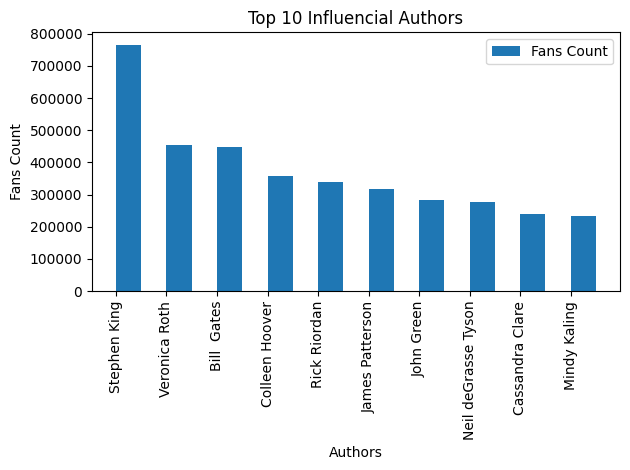

In [ ]:
# Sort the DataFrame by 'fans_count' and then by the length of 'work_ids' list in descending order
sorted_df = df_authors.sort_values(by=['fans_count', 'works_count'], ascending=[False, False])
top_authors = sorted_df.head(10)


# Plot 10 most influencial
bar_width = 0.5
p1 = plt.bar([x + bar_width for x in range(10)], top_authors['fans_count'], bar_width, label='Fans Count')
plt.xlabel('Authors')
plt.xticks([x + bar_width / 2 for x in range(10)], top_authors['name'], rotation='vertical')
plt.ylabel('Fans Count')
plt.title('Top 10 Influencial Authors')
plt.legend()
plt.tight_layout()
plt.show()


# The most influencial authors according to this method is Stephen King

In [ ]:
# RUN ONCE
# I iterate to create top_authors_books which I will use to analyse the books of the top 10 most influencial authors

top_authors_list = list(top_authors['id']) # Make a list with the authors_id
filtered_chunks = []

# Iterate through chunks and filter by the 10 author_ids
for chk in chunks:
    filtered_chunk = chk[chk['author_id'].isin(top_authors_list)]
    filtered_chunks.append(filtered_chunk)

top_authors_books = pd.concat(filtered_chunks, ignore_index=True) # concatenate filtered chunks

### RQ5-2. Have they published any series of books? If any, extract the longest series name among these authors.


In [ ]:
authors_with_series = top_authors_books[top_authors_books['series_name'].notna() & (top_authors_books['series_name'] != '')] # I exclude all the books which are not part of a series

# For each author I iterate and create a authors_with_series_filtered variable with only their books
for name in authors_with_series['author_name'].unique():
    max_n = 0
    max_series = ''
    authors_with_series_filtered = authors_with_series[authors_with_series['author_name'] == name]

    # Now for each serie I take the maximum series_position
    for serie in authors_with_series_filtered['series_name'].unique():
        series_filtered = authors_with_series_filtered[authors_with_series_filtered['series_name'] == serie]
        max_n_serie = 0
        for n in series_filtered['series_position'].unique():
            try:
                n = int(n)
                if n > max_n_serie:
                    max_n_serie = n
            except ValueError: # Some values are not accepted because they contain other char
                pass
        if max_n_serie > max_n: # If serie with maximum value set name and number of part of that serie
            max_n = max_n_serie
            max_series = serie

    print("- " + str(name) + "'s longest series is: " + max_series + " with " + str(max_n) + " Parts")

# Bill Gates and Mindy Kailing do not have any series of book. Below you can find the longest series:

- Stephen King's longest series is: Batman (1940-2011) with 400 Parts
- James Patterson's longest series is: Alex Cross with 23 Parts
- Neil deGrasse Tyson's longest series is: Merlin with 2 Parts
- Rick Riordan's longest series is: The 39 Clues with 11 Parts
- Cassandra Clare's longest series is: The Bane Chronicles with 11 Parts
- John Green's longest series is: Zombicorns with 2 Parts
- Veronica Roth's longest series is: Divergent with 3 Parts
- Colleen Hoover's longest series is: Slammed with 3 Parts


### RQ5-3. How many of these authors have been published in different formats? Provide a meaningful chart on the distribution of the formats and comment on it.


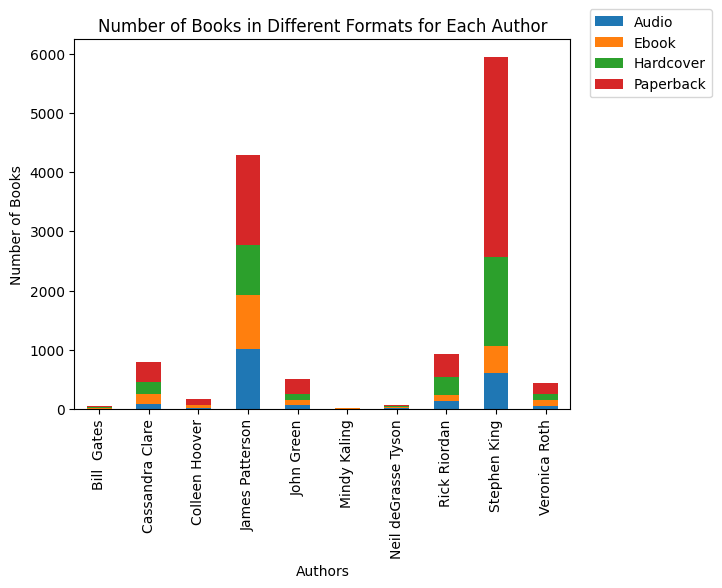

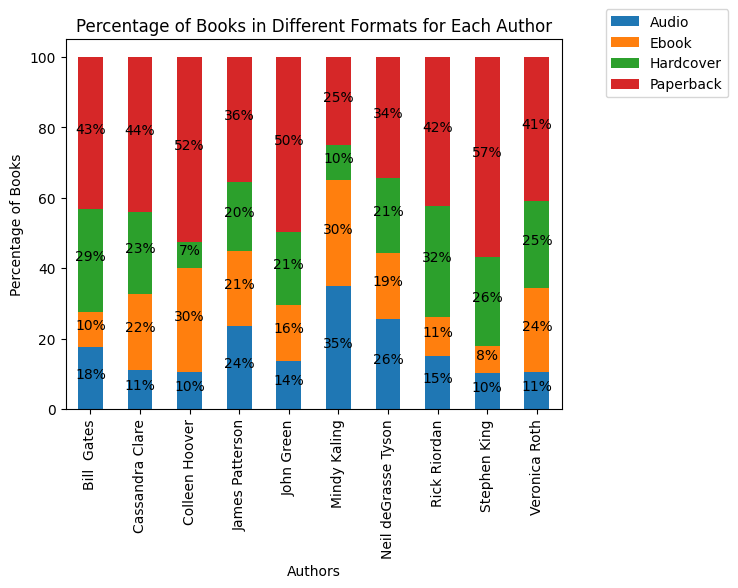

In [ ]:
# Too many formats, I created a mapping to create a column named standar_formats
format_mapping = {
    'Paperback': 'Paperback',
    'Hardcover': 'Hardcover',
    'Mass Market Paperback': 'Paperback',
    'Audio CD': 'Audio',
    'Library Binding': 'Hardcover',
    'Rústica bolsillo': 'Paperback',
    'Unknown Binding': 'Hardcover',
    'Audio Cassette': 'Audio',
    'ebook': 'Ebook',
    'Audio': 'Audio',
    'Hardcover, Book and Bookend Gift Set': 'Hardcover',
    'Hardcover, Sewn Binding, Paper Dust Jacket': 'Hardcover',
    'Audiobook': 'Audio',
    'MP3 CD': 'Audio',
    'Leather Bound': 'Hardcover',
    'Boxed Set': 'Hardcover',
    'MP3 Book': 'Audio',
    'School &amp; Library Binding': 'Hardcover',
    'Playaway Audiobook': 'Audio',
    'Product Bundle': 'Paperback',
    'Pamphlet': 'Paperback',
    'CD-ROM': 'Audio',
    'Turtleback': 'Hardcover',
    'paper': 'Paperback',
    'Flexcover': 'Paperback',
    'Hardcover + CD': 'Hardcover',
    'Soft Cover': 'Paperback',
    'Large paperback boxed set': 'Paperback',
    'Paperback / شومیز - رقعی': 'Paperback',
    'Large Print': 'Paperback',
    'Kindle Edition': 'Ebook',
    'Spiral-bound': 'Paperback',
    'Loose Leaf': 'Paperback',
    'Microsoft Reader Edition': 'Paperback',
    'Broché': 'Paperback',
    'Paperback &amp; Audio CD': 'Paperback',
    'Hardback': 'Hardcover',
    'Board Book': 'Hardcover',
    'Твердый переплет (Hardcover)': 'Hardcover',
    'Preloaded Digital Audio Player': 'Audio',
    'Postcard book': 'Paperback',
    'Unabridged Audiobook Download': 'Audio',
    'MP3': 'Audio',
    'Brochura (Paperback)': 'Paperback',
    'Hard Cover (gebonden)': 'Hardcover',
    'Trade Paperback': 'Paperback',
    'Kindle': 'Ebook',
    'Paperback and CD': 'Paperback',
    'Capa Mole': 'Paperback',
    'Fine Binding': 'Hardcover',
    'Paperback with flaps': 'Paperback',
    'audiobook': 'Audio',
    'Preloaded Digital Audio Player with earbuds': 'Audio',
    'Audible Audio': 'Audio',
    'Copertina rigida': 'Hardcover',
    'MP3 on CD': 'Audio',
    'DVD': 'Audio',
    '創元推理文庫': 'Paperback',
    'Board book': 'Hardcover',
    'audio': 'Audio',
    'hardback': 'Hardcover',
    'Paperback, Paper Dust Jacket': 'Paperback',
    'Videocassette': 'Audio',
    'Kindle Edition with Audio/Video': 'Ebook',
    'Slipcased Hardcover': 'Hardcover',
    'Audio Playaway': 'Audio',
    'Audible.com': 'Audio',
    'Leatherette': 'Hardcover',
    'Flexband': 'Paperback'
}

df = top_authors_books
df['standard_format'] = df['format'].map(format_mapping)
top_authors_books = df[df['standard_format'].notna() & (df['standard_format'] != '')] # Clear from NA values and ''

# Count the number of books in each format for each author
format_counts = top_authors_books.groupby(['author_name', 'standard_format']).size().unstack(fill_value=0)

# This graph is good but it's not reaally clear the distribution of the books, I decided to make in terms of percentage in the second graph
format_counts.plot(kind='bar', stacked=True, ax=plt.gca())
plt.xlabel('Authors')
plt.ylabel('Number of Books')
plt.title('Number of Books in Different Formats for Each Author')
plt.legend(bbox_to_anchor=(1.3, 1.10))
plt.show()

# Normalize the format_counts to represent percentages
row_sums = format_counts.sum(axis=1)
normalized_format_counts = format_counts.div(row_sums, axis=0) * 100

# Plot second graph
ax = normalized_format_counts.plot(kind='bar', stacked=True, ax=plt.gca())
plt.xlabel('Authors')
plt.ylabel('Percentage of Books')
plt.title('Percentage of Books in Different Formats for Each Author')
plt.legend(bbox_to_anchor=(1.35, 1.10))

for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    percentage = height
    if percentage > 0:
        ax.annotate(f'{percentage:.0f}%', (x + width/2, y + height/2), ha='center')

plt.show()

# the preferred format is paperback cover. If we consider Ebook and Audio to be the more sustainable option we can say that of the 10 best authors only Mindy Kailing was the one which delivered her content in a more sustainable fortmat.


### RQ5-4. Provide information about the general response from readers (number of fans, average rating, number of reviews, etc.), divide the authors by gender, and comment about anything eventually related to “structural bias.”


In [ ]:
# Divide male authors from female authors.
male_authors = top_authors[top_authors['gender'] == 'male']
female_authors = top_authors[top_authors['gender'] == 'female']
male_authors_list = list(male_authors['id'])
male_authors_list.extend([1406384, 12855, 23470]) # Some genders are not specified in lighter_authors.json. Through a quick research none identified in other genders. We therefore added them to their biological sex.
female_authors_list = list(female_authors['id'])
female_authors_list.append(194416)

# create variable male_books and female_books including all the books for each gender (Only two were present in top 10 authors so I divided in two categories)
male_books = top_authors_books[top_authors_books['author_id'].isin(male_authors_list)]
female_books = top_authors_books[top_authors_books['author_id'].isin(female_authors_list)]


# Process data
male_fanscount = male_authors['fans_count'].mean()
print("- Average male fans count is: " + str(round(male_fanscount, 1)))
female_fanscount = female_authors['fans_count'].mean()
print("- Average female fans count is: " + str(round(female_fanscount, 1)))

male_avg_rating = male_authors['average_rating'].mean()
print("- Average male rating is: " + str(round(male_avg_rating, 1)))
female_avg_rating = female_authors['average_rating'].mean()
print("- Average female rating is: " + str(round(female_avg_rating, 1)))

male_ratingcount = male_authors['ratings_count'].mean()
print("- Average male rating count is: " + str(round(male_ratingcount, 1)))
female_ratingcount = female_authors['ratings_count'].mean()
print("- Average female rating count is: " + str(round(female_ratingcount, 1)))

male_reviewscount = male_authors['text_reviews_count'].mean()
print("- Average male text reviews count is: " + str(round(male_reviewscount, 1)))
female_reviewscount = female_authors['text_reviews_count'].mean()
print("- Average female text reviews count is: " + str(round(female_reviewscount, 1)))

# Even though male authors have a larger fan base, larger rating count and larger reviews count, female authors tend to have an higher rating. The structural bias might manifest in various ways, such as the promotion of books by male authors over female authors, leading to differences in readership and reviews. The data however doesn't provide enough context to confirm this.


- Average male fans count is: 474140.3
- Average female fans count is: 350183.7
- Average male rating is: 4.1
- Average female rating is: 4.2
- Average male rating count is: 10284793.0
- Average female rating count is: 5126751.3
- Average male text reviews count is: 432107.0
- Average female text reviews count is: 311170.7


---
# [RQ6]

### RQ6-1. Provide the average time gap between two subsequent publications for a series of books and those not belonging to a series. What do you expect to see, and what is the actual answer to this question?


In [ ]:
# Some publication date are in a wrong format, here I clean all my data.
df_top_authors_books = top_authors_books[pd.to_datetime(top_authors_books['original_publication_date'], errors='coerce').notnull()]
df_top_authors_books['original_publication_date'] = pd.to_datetime(df_top_authors_books['original_publication_date'])

# I don't want blocks of edition (e.g. 'Harry Potter 1-7) because this would finding the difference in publication date extremely hard so i clean the serie_book variable to not inlcude thos with series_position not int or float
series_books = df_top_authors_books[df_top_authors_books['series_name'].notna() & (df_top_authors_books['series_name'] != '')]
series_books['series_position'] = pd.to_numeric(series_books['series_position'], errors='coerce')
series_books = series_books[pd.notna(series_books['series_position']) & (series_books['series_position'].apply(lambda x: isinstance(x, (int, float))))]

# Create a non_series_variable
non_series_books = df_top_authors_books[df_top_authors_books['series_name'].isna() | (df_top_authors_books['series_name'] == '')]

time_differences_series = []
time_differences_non_series = []

# For each author in series_books create a variable named authors_book and select the minmum original_publication_date for each (Same work_id sometimes have different original_publication_date)
for name in series_books['author_name'].unique():
    author_books = series_books[series_books['author_name'] == name]
    min_publication_dates = author_books.groupby('work_id')['original_publication_date'].min()
    min_publication_dates = min_publication_dates.sort_values(ascending=True)
    prev_date = None

    # Calculate time_difference for each book compared to the previously published one IF the days in between publishing is > than 60 days. This is to exclude the publishing of different editions (e.g. Different editions of same book with a time_difference of 1 day)
    for work_id, pub_date in min_publication_dates.items():
        if prev_date is not None:
            time_difference = (pub_date - prev_date).days
            if time_difference > 60:
              time_differences_series.append(time_difference)
        prev_date = pub_date

average_time_difference = sum(time_differences_series) / len(time_differences_series)
print(f"Average Time Difference for book in series: {round(average_time_difference, 1)} days")

# For each author in non_series_books create a variable named authors_book and select the minmum original_publication_date for each (Same work_id sometimes have different original_publication_date)
for name in non_series_books['author_name'].unique():
    author_books = non_series_books[non_series_books['author_name'] == name]
    min_publication_dates = author_books.groupby('work_id')['original_publication_date'].min()
    min_publication_dates = min_publication_dates.sort_values(ascending=True)
    prev_date = None

    # Calculate time_difference for each book compared to the previously published one IF the days in between publishing is > than 60 days. This is to exclude the publishing of different editions (e.g. Different editions of same book with a time_difference of 1 day)
    for work_id, pub_date in min_publication_dates.items():
        if prev_date is not None:
            time_difference = (pub_date - prev_date).days
            if time_difference > 60:
                time_differences_non_series.append(time_difference)
        prev_date = pub_date

average_time_difference = sum(time_differences_non_series) / len(time_differences_non_series)
print(f"Average Time Difference for book not in series: {round(average_time_difference, 1)} days")

# I expectected to see authors publishing books which already have a high follow in order to profit the most out of them. The results confirmed this on average authors tend to publish more often books which are in series. 288.2 days vs 357.5 days.


Average Time Difference for book in series: 288.2 days
Average Time Difference for book not in series: 357.5 days


<ipython-input-22-f7a3dc090586>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_top_authors_books['original_publication_date'] = pd.to_datetime(df_top_authors_books['original_publication_date'])
<ipython-input-22-f7a3dc090586>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  series_books['series_position'] = pd.to_numeric(series_books['series_position'], errors='coerce')


### RQ6-2. For each of the authors, give a convenient plot showing how many books has the given author published UP TO a given year. Are these authors contemporary with each other? Can you notice a range of years where their production rate was higher?


2020


<ipython-input-23-f9857955a279>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_top_authors_books['original_publication_date'] = pd.to_datetime(df_top_authors_books['original_publication_date'])


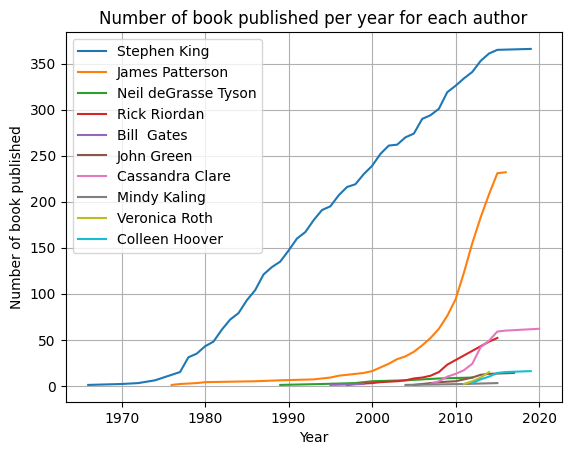

In [ ]:
# Input maximum year
year = int(input())

# Clean data through the same processes used for the other exercises
df_top_authors_books = top_authors_books[pd.to_datetime(top_authors_books['original_publication_date'], errors='coerce').notnull()]
df_top_authors_books['original_publication_date'] = pd.to_datetime(df_top_authors_books['original_publication_date'])
df_top_authors_books = df_top_authors_books[df_top_authors_books['original_publication_date'].dt.year <= year]

main_dict = {}

# Creates a dictionary with key value the authors_name
for name in df_top_authors_books['author_name'].unique():
    top10_authors_filtered = df_top_authors_books[df_top_authors_books['author_name'] == name]
    min_publication_dates = top10_authors_filtered.groupby('work_id')['original_publication_date'].min()
    min_publication_dates = min_publication_dates.sort_values(ascending=True)

    author_dict = {}
    work_ids_list = []

    # Appends work_id unique to the item in the inner dictionaries for each year
    for work_id, pub_date in min_publication_dates.items():
        year = pub_date.year
        work_ids_list.append(work_id)
        author_dict[year] = work_ids_list.copy()
    main_dict[name] = author_dict

author_year_counts = {}

# Iterate through the main_dict to calculate the counts of work_ids for each author and year
for author, years in main_dict.items():
    author_counts = {}
    for year, work_ids in years.items():
        author_counts[year] = len(work_ids)
    author_year_counts[author] = author_counts

# Plotting the graph for each author
for author, counts in author_year_counts.items():
    years = list(counts.keys())
    work_id_counts = list(counts.values())
    plt.plot(years, work_id_counts, label=author)

plt.xlabel('Year')
plt.ylabel('Number of book published')
plt.title('Number of book published per year for each author')
plt.legend()
plt.grid(True)
plt.show()

# There are two groups of authors one can be seen started publishing book after 2000 and the other started publishing book before 2000. Both group still publish books to this date. They can all be considered contemporary authors.
# Published before 2000: Stephen King, Neil deGrasse Tyson, Bill Gates, Rick Riordan, James Patterson
# Published after 2000: Veronica Roth, Mindy Kaling, Colleen Hoover, Cassandra Clare



---
# [RQ7]

### RQ7-1. Estimate the probability that a book has over 30% of the ratings above 4.

The result is 52.02%.

In our analysis we saw that the records that are not books do not contain the number of pages, or contain an empty string. We have also dropped the record with 'author_name' = 'NOT A BOOK'. The last that we did is to consider only the books whose 'rating_dist' is well formatted.

Since the rating distribution is discrete, i.e. can assume only integer values from 1 to 5 included, our probability coincides with the *probability that a book has over 30% of the ratings equals to 5*.

For every chunk of the data we choosed to use vectorization using the apply method. This allowed us to lower the execution time of the script.

In [ ]:
# First of all one should check that the total is correct. Should we do that?
# Alsi check that the total is the same as rating_counts?

# Check if is a book looking at num_pages (apart from format)

def parse_ratings(ratings: str) -> dict:
  """
  This funcion parses a string like '5:1674064|4:664833|3:231195|2:41699|1:16215|total:2628006'
  and returns a dictionary where the keys are '1','2','3','4','5','total' and the values are the
  corresponding rating counts
  """
  result = dict()
  # We check if the string is correctly formatted. Otherwise we return an
  # empty dictionary
  if re.match(r'^(\d+:\d+\|)*total:\d+$', ratings):
    ratings = ratings.split("|")
    for item in ratings:
      index, value = item.split(":")
      result[index] = int(value)

  return result

num_books_above_30 = 0
num_total_books = 0

reset_chunks()
for chk in chunks:
  tmp = chk[(chk.ratings_count > 0) & (chk.num_pages.notna()) & (chk.num_pages.str.strip() != '') & (chk.author_name != 'NOT A BOOK')][["id", "rating_dist"]]

  # Parse the string 'rating_dist' and transform it into a dictionary
  # We will add a new column to the temporary DataFrame
  tmp['rating_dict'] = tmp['rating_dist'].apply(parse_ratings)

  # Remove the records where the rating_dist field is empty or the total of the ratings is 0
  tmp = tmp[tmp['rating_dict'].apply(lambda x: (x != '') and 'total' in x and x['total'] > 0)]

  # Add the columns we will use later to compute the desired probability
  tmp['percentage_above_4'] = tmp.apply(lambda row: row['rating_dict']['5'] / row['rating_dict']['total'], axis = 1)
  tmp['rating_total'] = tmp.apply(lambda row: row['rating_dict']['total'], axis = 1)

  # Now we can use our data to update the variables we use to compute the probability.
  # Update the total books number (this is necessary because we have
  # filtered the rows that do not contain a book)
  num_total_books += tmp.shape[0]
  num_books_above_30 += tmp[tmp.percentage_above_4 >= 0.3].shape[0]

prob = num_books_above_30 / num_total_books * 100
print(f"The probability that a book has over 30% of ratings above 4 is: {prob: .2f}")

The probability that a book has over 30% of ratings above 4 is:  52.02


### RQ7-2. Estimate the probability that an author publishes a new book within two years from its last work.

To compute this probability we want to evaluate the ratio

$$\frac{\sum_{\text{author}}\text{\# of intervals} \neq 0 \text{ of books published within two years by that author }}{\sum_{\text{author}}\text{\# of intervals} \neq 0 \text{ among consecutive publications by that author}}$$
<br>

We assume that a book must have a number of pages that is neither NaN or an empty string. In this way we try to not consider records with 'format' like 'Audio CDs' or 'MP3'.

For the same reason we consider only those books whose 'original_publication_date' is not empty and does not raise an error while trying to convert it to a DateTime format. We found that some date are negative and we decided to not consider those records.

Our strategy begins with, once retrieved the useful attributes, ordering the DataFrame by 'author_id' and 'original_publication_date'. Then we compute all the date differences by consecutive publications of the same author.
We choosed remove the records with time difference = 0 because:
* we are interested in intervals
* we do not consider the authors that have published only one book

At this point we can count the books that have pubblication date difference within two years (730 days) and the total number of date differences among consecutive publications.


The probability that an author publishes a new book within two years from its last work is 20.87%.

In the end we choose to write a function that, given an author_id, calculates the probability that he/her publishes a new book within two years. In return 0 also for authors that have published only one book.

In [ ]:
# First of all we filter the books dataset and we consider only the
# columns that we need

books = pd.DataFrame()

reset_chunks()
for chk in chunks:
  # Consider only the records with valid num_pages and original_pubblication_date that is not empty
  tmp = chk[(chk.num_pages.notna()) & (chk.num_pages.str.strip() != '') & (chk.original_publication_date.str.strip() != '')][['id','author_id','original_publication_date']]
  books = pd.concat([books, tmp], ignore_index = True)

# We find the ids of books with original_publication_date that is not convertible to DateTime
incorrect_dates = books[pd.to_datetime(books['original_publication_date'], errors='coerce').isna()]
incorrect_dates_id = incorrect_dates['id'].tolist()

# Drop incorrect records from our dataframe
books = books[~books['id'].isin(incorrect_dates_id)]


In [ ]:
# Now we can convert the date to a correct DateTime format
# Records with only the year are set by default month=January and day=01
books['original_publication_date'] = pd.to_datetime(books['original_publication_date'])

# We order the dataframe by author_id and original_publication_date
books = books.sort_values(by = ['author_id','original_publication_date'], ascending = True)

# Here we calculate all the differences between two consecutive publications
# of each single author, using a function and apply()
def calculate_intervals(grouped_by_author):
    return grouped_by_author['original_publication_date'].diff()

# Apply the custom function to each author group
books['pub_date_interval'] = books.groupby('author_id').apply(calculate_intervals).reset_index(level = 0, drop = True)

total = books.shape[0]

# Now we remove the books where pub_date_interval = 0. This is done for a correct
# computation of the probability. We remove books published in the same day.
# In this way also remove the authors that have published only one book
# (and so they cannot have published two books within two years).
books = books[books['pub_date_interval'] > pd.Timedelta(days=0)]

# Now we get, grouped by author, the number of books that have been published within two years
# We remove the entries where the interval is zero, which corresponds to publications in the same day,
# that we assume to be impossible

books_within_2years = books[books['pub_date_interval'] <= pd.Timedelta(days=730)]

# Evaluate the desired probability
prob = books_within_2years.shape[0] / total  * 100

print("The number of books published within two years: ", books_within_2years.shape[0])
print("The probability that an author publishes a new book within two years from its last work: ", round(prob, 2),"%")

The number of books published withintwo years:  788498
The probability that an author publishes a new book within two years from its last work:  20.87 %


In [ ]:
def prob_within_2years(author_id: int) -> float:
  """
  Given an author_id, calculates the probability that he/her publishes a
  new book within two years. In return 0 also for authors that have published
  only one book.
  """
  books = pd.DataFrame()

  reset_chunks()
  for chk in chunks:
    # Consider only the records with valid num_pages and original_pubblication_date that is not empty
    tmp = chk[(chk.num_pages.notna()) & (chk.num_pages.str.strip() != '') & (chk.original_publication_date.str.strip() != '') & (chk.author_id == author_id)][['id','author_id','original_publication_date']]
    books = pd.concat([books, tmp], ignore_index = True)

  # We find the ids of books with original_publication_date that is not convertible to DateTime
  incorrect_dates = books[pd.to_datetime(books['original_publication_date'], errors='coerce').isna()]
  incorrect_dates_id = incorrect_dates['id'].tolist()

  # Drop incorrect records from our dataframe
  books = books[~books['id'].isin(incorrect_dates_id)]

  if books.shape[0] == 0: return 0

  # Now we can convert the date to a correct DateTime format
  # Records with only the year are set by default month=January and day=01
  books['original_publication_date'] = pd.to_datetime(books['original_publication_date'])

  # We order the dataframe by author_id and original_publication_date
  books = books.sort_values(by = ['author_id','original_publication_date'], ascending = True)

  # Here we calculate all the differences between two consecutive publications
  books['pub_date_interval'] = books['original_publication_date'].diff().reset_index(level = 0, drop = True)

  total = books.shape[0]

  books = books[books['pub_date_interval'] > pd.Timedelta(days=0)]

  if books.shape[0] == 0: return 0

  books_within_2years = books[books['pub_date_interval'] <= pd.Timedelta(days=730)]

  # Evaluate the desired probability
  prob = books_within_2years.shape[0] / total  * 100

  return prob

In [ ]:
# For example we test the function prob_within_2years() with
# 'Douglas Adams' that has author_id = 4 (he's dead, but in the database there
# is no information about it)
douglas_prob = prob_within_2years(4)
print('The probability that Douglas Adams publishes a new book within two years from its last work is: ', round(douglas_prob, 2))

The probability that Douglas Adams publishes a new book within two years from its last work is:  3.61%


### RQ7-3. In the file list.json, you will find a peculiar list named "The Worst Books of All Time." Estimate the probability of a book being included in this list, knowing it has more than 700 pages.

To evaluate this probability we have to use the conditional probability. In other word:

$$\mathbb{P}(\text{a book is in 'The Worst Books of All Time'} | \text{the book has more than 700 pages}) =\\ =  \frac{\text{joint probability}}{\text{marginal probability}}$$
<br> where
$$\text{joint probability} = \mathbb{P}(\text{a book is in 'The Worst Books of All Time'}\cap \text{the book has more than 700 pages})$$
<br>and
$$\text{marginal probability} = \mathbb{P}(\text{a book has more than 700 pages})$$

The desired probability is 0.002%. <br>This means that among the books with more than 700 pages, only 1 out of 50000 is in 'The Worst Books of All TIme' list.

In [ ]:
# First of all we retrive the books inside 'The Worst Books of All Time'
# It is the first record (the one with id == 2) inside the 'list.json' dataset

worst_book_record = pd.Series(dtype = object)

list_chunks = pd.read_json(filepath_list, lines = True, chunksize = 10)
for chk in list_chunks:
  worst_books_record = chk.loc[0]
  break

# List containing the worst books' ids
books_json = worst_books_record['books']
print("Number of books in 'The Worst Books of All Time' list:", len(books_json))

# Creating a list with all the book ids as integer
worst_book_ids = [int(item['book_id']) for item in books_json]

Number of books in 'The Worst Books of All Time' list: 7393


In [ ]:
# Now we look into the books daatset and we save a DataFrame with 'id' and
# 'num_pages' of the worst books
worst_books = pd.DataFrame(columns = ['id','num_pages'])

pages_list = list()

reset_chunks()
for chk in chunks:
  tmp = chk[chk['id'].astype(int).isin(worst_book_ids)][['id','num_pages']]
  worst_books = pd.concat([worst_books, tmp])

  # We also save the number of pages for all books, to evaluate the probability.
  # We do not consider the books with empty number of pages
  pages_list += chk[chk['num_pages'].str.strip() != '']['num_pages'].tolist()


# The probability that a book is in the Worst Books List AND has more than 700 pages.
# First of all we remove records with invalid num_pages
worst_books = worst_books[worst_books['num_pages'].astype(str).str.strip() != '']
num_worst_moreThan700 = worst_books[worst_books['num_pages'].astype(int) > 700].shape[0]
prob_intersection = num_worst_moreThan700 / len(pages_list) * 100

print(f'The joint probability is: {round(prob_intersection,3)}%')

# The probability that a books has more than 700 pages
num_moreThan700 = len([x for x in pages_list if x > 700])
prob_moreThan700 = num_moreThan700 / len(pages_list) * 100

print(f'The marginal probability is: {round(prob_moreThan700,2)}%')

print(f'\nThe probability of a book being included in this list, knowing it has more than 700 pages, is: {round(prob_intersection / prob_moreThan700, 4 )}%')

The joint probability is: 0.006%
The marginal probability is: 2.81%

The probability of a book being included in this list, knowing it has more than 700 pages, is: 0.002%


### RQ7-4. Are the events X=’Being Included in The Worst Books of All Time list’ and Y=’Having more than 700 pages’ independent? Explain how you have obtained your answer.

From the probability theory we know that the two events are independent if and only if

$$\mathbb{P}(X \cap Y) = \mathbb{P}(X)\mathbb{P}(Y)$$

We have that:
*   $\mathbb{P}(X) \approx 0.187 $
*   $\mathbb{P}(Y) \approx 2.81 $
*   $\mathbb{P}(X \cap Y) \approx  0.00556$
*   $\mathbb{P}(X)\mathbb{P}(Y) \approx  0.525$

Since $\mathbb{P}(X \cap Y) \neq \mathbb{P}(X)\mathbb{P}(Y)$ we found that $X$ and $Y$ are not independent.



In [ ]:
prob_x = len(worst_book_ids) / len(pages_list) * 100
print('P(X) = ',round(prob_x, 8))
print('P(Y) = ',round(prob_moreThan700, 8))
print('\nP(X)P(Y) = ',round(prob_x*prob_moreThan700, 8))
print('P(X intersection Y) = ',round(prob_intersection, 8))

P(X) =  0.18689977
P(Y) =  2.80918476

P(X)P(Y) =  0.525036
P(X intersection Y) =  0.00556174


---
# [RQ8]

### RQ-1. Can you demonstrate that readers usually rate the longest books as the worst? 

To answer this question we can try to compute the correlation coefficient to check if there is some sort of correlation between the length of the book (number of pages) and the ratings (average ratings).

> The correlation coefficient ranges from -1 to 1. <br>
A positive correlation coefficient indicates that as the number of pages increases, the average rating also increases, while a negative correlation coefficient indicates that as the number of pages increases, the average rating decreases. <br>
If the correlation coefficient is close to -1, it means that there is a strong negative correlation between the number of pages and the average rating, which suggests that readers usually rate the longest books as the worst

We will filter out the outliers of the number of pages distribution with the interquartile range method.


In [ ]:
#Let's compute the correlation coefficient
chunks = pd.read_json(filepath_books, lines = True, chunksize = 10000)

whole_df = []
for chunk in chunks:
  #Let's do some data cleaning before getting into the correlation
  chunk["num_pages"].replace('', np.NaN, inplace = True)
  chunk["num_pages"] = chunk["num_pages"].astype(float)
  chunk["num_pages"].replace(0.00, np.NaN, inplace = True)
  chunk["average_rating"].replace('', np.NaN, inplace = True)
  chunk["average_rating"].replace(0.00, np.NaN, inplace = True)

  chunk = chunk[~chunk["num_pages"].isna()]
  chunk = chunk[~chunk["average_rating"].isna()]

  #To filter out outliers values
  Q1 = chunk['num_pages'].quantile(0.25)
  Q3 = chunk['num_pages'].quantile(0.75)
  IQR = Q3 - Q1

  chunk = chunk[~((chunk['num_pages'] < (Q1 - 1.5 * IQR)) | (chunk['num_pages'] > (Q3 + 1.5 * IQR)))]

  ch = chunk[["num_pages","average_rating"]]
  whole_df.append(ch) #put chunks in a list

books_df = pd.concat(whole_df) # Concatenate the chunks into a single DataFrame
corr_coeff = books_df["num_pages"].corr(books_df["average_rating"]) # Compute the correlation coefficient

print("\033[1m" + "The correlation coefficient is:" + "\033[0m" + str(corr_coeff)) #0.06024192758027851

The correlation coefficien is:0.06024192758027851


> The correlation coefficient we obtained (0.06024192758027851) is telling us that effectively there is no strong linear trend between the variables "average rating" and "number of pages". <br>
The sign of the coefficient is positive, which suggests that as one variable increases the other variable tends to increase too. <br>
Also, since the absolute value of the coefficient is very close to 0, the relationship between the two variables can be described as "very weak".


We can now try to do a scatterplot and a linear regression to see if they overlap.
If they don't overlap it means, as we just saw with the correlation coefficient, that the two variables don't have a linear relationship.

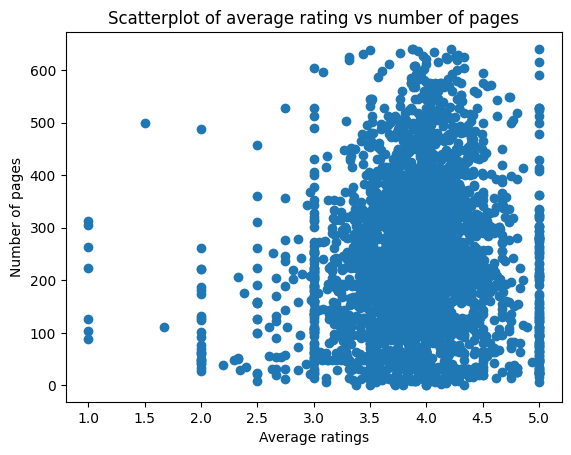

In [ ]:
#scatterplot
chunks = pd.read_json(filepath_books, lines = True, chunksize = 10000)

for chunk in chunks:
  #Let's do some data cleaning before getting into the correlation
  chunk["num_pages"].replace('', np.NaN, inplace = True)
  chunk["num_pages"] = chunk["num_pages"].astype(float)
  chunk["num_pages"].replace(0.00, np.NaN, inplace = True)
  #chunk["num_pages"] = pd.to_numeric(chunk["num_pages"], errors='coerce') #because it's an object datatype
  chunk["average_rating"].replace('', np.NaN, inplace = True)
  chunk["average_rating"].replace(0.00, np.NaN, inplace = True)

  chunk = chunk[~chunk["num_pages"].isna()]
  chunk = chunk[~chunk["average_rating"].isna()]

  #To filter out outliers values
  Q1 = chunk['num_pages'].quantile(0.25)
  Q3 = chunk['num_pages'].quantile(0.75)
  IQR = Q3 - Q1

  chunk = chunk[~((chunk['num_pages'] < (Q1 - 1.5 * IQR)) | (chunk['num_pages'] > (Q3 + 1.5 * IQR)))]

  ch = chunk[["num_pages","average_rating"]]

#Scatterplot
plt.scatter(ch['average_rating'], ch['num_pages'])

plt.xlabel('Average ratings')
plt.ylabel('Number of pages')
plt.title('Scatterplot of average rating vs number of pages')
plt.show()

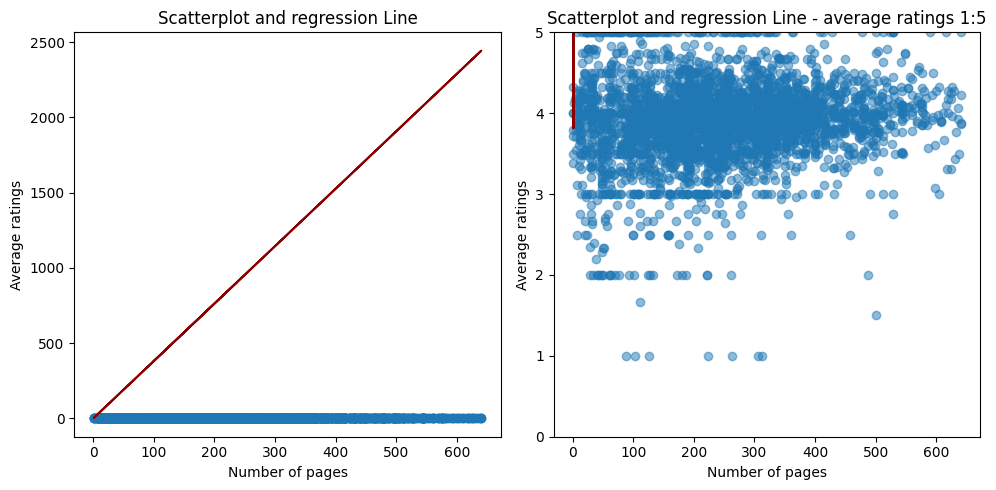

In [ ]:
#Linear regression
chunks = pd.read_json(filepath_books, lines = True, chunksize = 10000)

for chunk in chunks:
  #Let's do some data cleaning before getting into the correlation
  chunk["num_pages"].replace('', np.NaN, inplace = True)
  chunk["num_pages"] = chunk["num_pages"].astype(float)
  chunk["num_pages"].replace(0.00, np.NaN, inplace = True)
  #chunk["num_pages"] = pd.to_numeric(chunk["num_pages"], errors='coerce') #because it's an object datatype
  chunk["average_rating"].replace('', np.NaN, inplace = True)
  chunk["average_rating"].replace(0.00, np.NaN, inplace = True)

  chunk = chunk[~chunk["num_pages"].isna()]
  chunk = chunk[~chunk["average_rating"].isna()]

  #To filter out outliers values
  Q1 = chunk['num_pages'].quantile(0.25)
  Q3 = chunk['num_pages'].quantile(0.75)
  IQR = Q3 - Q1

  chunk = chunk[~((chunk['num_pages'] < (Q1 - 1.5 * IQR)) | (chunk['num_pages'] > (Q3 + 1.5 * IQR)))]

  ch = chunk[["num_pages","average_rating"]]

#Let's fit a linear regression model using OLS (Ordinary LEast Square) function:
import statsmodels.formula.api as smf

model = smf.ols(formula='average_rating ~ num_pages', data= ch).fit()

#regression model
m, b = model.params
x = ch['num_pages']
y_pred = m*x + b

#Let's plot the scatterplot and the regresion model:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Create the scatterplot and the regression line for the first subplot
axs[0].scatter(x, ch['average_rating'], alpha=0.5) #alpha = 0.5 -> makes the scatterplot a bit transparent
axs[0].plot(x, y_pred, color='darkred')
axs[0].set_xlabel('Number of pages')
axs[0].set_ylabel('Average ratings')
axs[0].set_title('Scatterplot and regression Line')

# Create the scatterplot and the regression line for the second subplot
axs[1].scatter(x, ch['average_rating'], alpha=0.5)
axs[1].plot(x, y_pred, color='darkred')
axs[1].set_xlabel('Number of pages')
axs[1].set_ylabel('Average ratings')
axs[1].set_title('Scatterplot and regression Line - average ratings 1:5')
axs[1].set_ylim([0,5])

plt.tight_layout()
plt.show()


> We can see from the plots that the scatterplot and the linear regression don't overlap.

> This means that the linear model doesn't capture the relationship between the lenght of the books (represented by the number of pages) and the average ratings.

We can now assert that both the correlation coefficient and the visual representations tells us that the relationship between lenght of the books and the average ratings is not linear.

### RQ 8-2. Compare the average rate distribution for English and non-English books with a proper statistical procedure. What can you conclude about those two groups?

In [ ]:
#Let's do some data cleaning on the languages first:

def language_translate(language):
  if language == "English" or language == "eng" or language == "en" or language == "en-US" or language == "en-GB" or language == "en-CA" or language == "en-IN":
    return "English"
  elif language == '':
    return np.NaN
  else :
    return "Non-English"

chunks = pd.read_json(filepath_books, lines = True, chunksize = 10000)

language_df = pd.DataFrame()
for chunk in chunks:
  chunk["language"] = chunk["language"].astype(str)
  chunk["language"] = chunk["language"].map(language_translate)
  chunk["average_rating"].replace(0.00, np.NaN, inplace = True)
  chunk = chunk[~chunk["language"].isna()]
  chunk = chunk[~chunk["average_rating"].isna()]
  language_df = pd.concat([language_df, chunk[["language", "average_rating"]]])

#Let's compute the Kologorv-smirnov test with the "two-sided" method, in which the hypothesis are the following:
#Null hypothesis = the two distributions are identical, F(x)=G(x) for all x
#Alternative hypothesis = the distributions are not identical

from scipy import stats
from scipy.stats import ks_2samp

english_books = language_df[language_df["language"] == "English"]
non_english_books = language_df[language_df["language"] == "Non-English"]

kolmogorov_smirnov = ks_2samp(english_books["average_rating"]*len(english_books), non_english_books["average_rating"]*len(non_english_books))
t_test = stats.ttest_ind(english_books["average_rating"], non_english_books["average_rating"], equal_var = False, alternative= 'two-sided')
#Based on the p-value returned we can draw our conclusions


In [ ]:
print("\033[1m" + "Result of the Kolmogorv-smirnov test:" + "\033[0m" + str(kolmogorov_smirnov)) #KstestResult(statistic=0.8447379437280342, pvalue=0.0, statistic_location=4962735.0, statistic_sign=-1)
print("\033[1m" + "Result of the  t-test:" + "\033[0m" + str(t_test)) #TtestResult(statistic=93.74888774331474, pvalue=0.0, df=2387170.745196682)

Result of the Kolmogorv-smirnov test:KstestResult(statistic=0.8447379437280342, pvalue=0.0, statistic_location=4962735.0, statistic_sign=-1)
Result of the  t-test:TtestResult(statistic=93.74888774331474, pvalue=0.0, df=2387170.745196682)


> The **Kolmogorov-Smirnov test** is a nonparametric goodness-of-fit test used to determine whether two distributions differ and it's particularly useful when you have two samples coming from two populations that can be different. <br>
> Since the p-value we got for this test is < 0.05 we can reject the null hypothesis and conclude that the average rate English and non-English books distributions are different.

> Another test we can try is the  **T-test**, which is used to determine if there is a difference between the mean of two distributions. <br>
We choose the "two sample test" option, that is used to compare the means of two independent groups.
With the p-value we got from this test (< 0.05) we can reject the null hypothesis and say that we have evidence to conclude that the average ratings of English books and non-English books are different.

### RQ8-3. About the two groups in the previous question, extract helpful statistics like mode, mean, median, and quartiles, explaining their role in a box plot.

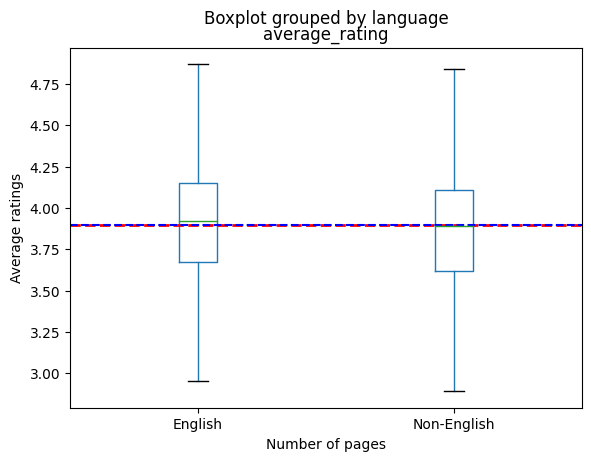

English books mode:4.0
Non-English books mode:4.0
Non-English books statistical summary:
count    1.102830e+06
mean     3.839130e+00
std      4.664131e-01
min      1.000000e+00
25%      3.620000e+00
50%      3.890000e+00
75%      4.110000e+00
max      5.000000e+00
Name: average_rating, dtype: float64
English books statistical summary:
count    1.456822e+06
mean     3.894574e+00
std      4.713672e-01
min      1.000000e+00
25%      3.670000e+00
50%      3.920000e+00
75%      4.150000e+00
max      5.000000e+00
Name: average_rating, dtype: float64


In [ ]:
#Let's do some data cleaning on the languages first:
def language_translate(language):
  if language == "English" or language == "eng" or language == "en" or language == "en-US" or language == "en-GB" or language == "en-CA" or language == "en-IN":
    return "English"
  elif language == '':
    return np.NaN
  else :
    return "Non-English"

chunks = pd.read_json(filepath_books, lines = True, chunksize = 10000)

language_df = pd.DataFrame()

for chunk in chunks:
  chunk["language"] = chunk["language"].astype(str)
  chunk["language"] = chunk["language"].map(language_translate)
  chunk["average_rating"].replace(0.00, np.NaN, inplace = True)
  chunk = chunk[~chunk["language"].isna()]
  chunk = chunk[~chunk["average_rating"].isna()]
  language_df = pd.concat([language_df, chunk[["language", "average_rating"]]])

english_books = language_df[language_df["language"] == "English"]
non_english_books = language_df[language_df["language"] == "Non-English"]

#Now let's compute the boxplot
english_books_mean = english_books["average_rating"].mean()
non_english_books_mean = english_books["average_rating"].mean()
boxplot = language_df.boxplot(column='average_rating', by='language', grid=False, showfliers = False)

plt.axhline(y=english_books_mean, color='r', linestyle='--', linewidth = 2)
plt.axhline(y=non_english_books_mean, color='b', linestyle='--')

plt.xlabel('Number of pages')
plt.ylabel('Average ratings')
plt.show()

#Since we can't extrapolate the mode and the mean from the boxplot we can compute them:
english_books_mode = english_books["average_rating"].mode().values[0]
print("\033[1m" + "English books mode:" + "\033[0m" + str(english_books_mode))

non_english_books_mode = non_english_books["average_rating"].mode().values[0]
print("\033[1m" + "Non-English books mode:" + "\033[0m" + str(non_english_books_mode))

#for the other statistics:
print("\033[1m" + "Non-English books statistical summary:" + "\033[0m\n" + str(non_english_books["average_rating"].describe()))
print("\033[1m" + "English books statistical summary:" + "\033[0m\n" + str(english_books["average_rating"].describe()))

> The boxplot is a type of plot that summarises the best the distribution of a dataset, by displaying a box with its five-number summary: the minimum, the first quartile (Q1), the median (Q2), the third quartile (Q3), and the maximum. <br>
It also shows the outliers and the distribution positive, null or negative skeweness based on the position of the median value.

1.   The **minimum** is the smallest value in the dataset, excluding any outliers.
2.   The **first Quartile (Q1)** corresponds to the 25th percentile.
3.   The **median** is the middle value in the dataset when the values are ordered, and it corresponds to the 50th percentile **(Q2)**.
4.   The **third Quartile (Q3)** corresponds to the 75th percentile.
5.   The **maximum** is the largest value in the dataset, excluding any outliers.

> The box in the boxplot represents the interquartile range (IQR), which is the range between the first quartile (Q1) and the third quartile (Q3). The line inside the box represents the median (Q2). The whiskers represent the range of the data within 1.5 times the IQR. Any data points outside this range are considered outliers and are represented as individual points on the plot.

> Other important statistical values that are not represented in the boxplot but can be retrieved with the describe() function are the mode and the mean. <br>
The **mode** is the most frequently occurring value in the dataset, while the **mean** is the sum of all the values in the dataset divided by the number of values.



### RQ8-4 It seems reasonable to assume that authors with more fans should have more reviews, but maybe their fans are a bit lazy. Confirm or reject this with a convenient statistical test or a predictive model.

We can tackle this problem by doing a linear regression analysis on the fans_count and text_reviews_count, and on the fans_count and ratings_count to see if they have a linear relationship:

In [ ]:
#Linear regression on text_reviews

#Let's fit a linear regression model using OLS (Ordinary LEast Square) function:
import statsmodels.formula.api as smf

model_text_review = smf.ols(formula='text_reviews_count ~ fans_count', data = authors).fit()

#regression model
m, b = model.params
x = authors['fans_count']
y_pred = m*x + b

print("\033[1m" + "fan - text review Linear regression:" + "\033[0m\n" + str(model_text_review.summary()))


#Linear regression on rating_count
model_rating = smf.ols(formula='ratings_count ~ fans_count', data = authors).fit()

#regression model
a, b = model.params
x = authors['fans_count']
y_pred = a*x + b

print("\033[1m" + "fan - ratings Linear regression:" + "\033[0m\n" + str(model_rating.summary()))

fan - text review Linear regression:
                            OLS Regression Results                            
Dep. Variable:     text_reviews_count   R-squared:                       0.167
Model:                            OLS   Adj. R-squared:                  0.167
Method:                 Least Squares   F-statistic:                 3.814e+04
Date:                Sun, 05 Nov 2023   Prob (F-statistic):               0.00
Time:                        19:53:51   Log-Likelihood:            -8.9942e+05
No. Observations:              189953   AIC:                         1.799e+06
Df Residuals:                  189951   BIC:                         1.799e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      

> From the results we obtained with the regression analysis summary, and in particular by looking at the fans_count coefficient, we can say that the fans of the authors of this dataset are a bit lazy. <br>
> That is because the coefficient of fans_count from linear regression 'ratings_count ~ fans_count' is much higher than the one of the linear regression 'text_reviews_count ~ fans_count'.

> In particular the fans_count coefficient (7.4041) from 'ratings_count ~ fans_count' means that for each additional fan, the ratings_count is expected to increase by 21.3144 units, assuming all other variables remain constant. On the other hand fans_count coefficient (1.6025) from the 'text_reviews_count ~ fans_count' means that for each additional fan, the text_reviews_count is expected to increase by 1.0064 units, assuming all other variables remain constant. <br>
This result points out that, for each additional fan, there are more ratings than text reviews count.



>

### RQ8-5 Provide a short survey about helpful statistical tests in data analysis and mining: focus on hypothesis design and the difference between parametric and nonparametric tests, explaining the reasons behind the choice of one of these two tests.

Hypothesis testing is a fundamental concept in statistics, which is used to determine whether a predictor variable has a statistically significant relationship with an outcome variable. <br>
Parametric and nonparametric test are two of the main types of statistical tests used in hypothesis testing; the choice between one of them is determined by the data's nature and the assumptions that can be made about the data.


> **Parametric tests** are used when the data follow a specific distribution, usually the normal distribution. They are based on the assumption that we have prior knowledge of the population distribution, or if not, we can approximate it to a normal distribution with the help of the Central Limit Theorem. <br>
Parametric tests have greater statistical power and include *regression tests*, *comparison tests*, and *correlation tests*.


> **Non-parametric tests** don't make many assumptions about the data and are useful when one or more of the common statistical assumptions are violated, for example when the data do not follow the normal distribution, or when the sample size isn't large enough to satisfy the requirements for parametric tests.   
The inferences they make aren't as strong as with parametric tests.

> The non-parametric tests include the *median test for one sample*, *comparison of two paired samples*, *comparison of two independent samples*, and *comparison of three or more samples*. <br>

Following a decision tree to choose the right statistical test for our data:
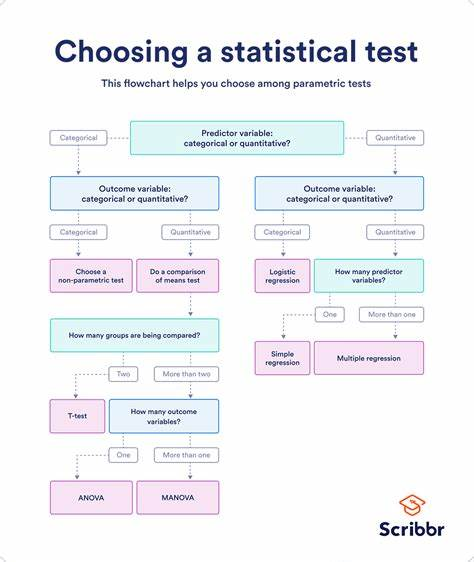











---
# [Bonus 1]

### Bonus1-1. Select one alternative library to Pandas (i.e., Dask, Polar, Vaex, Datatable, etc.), upload authors.json dataset, and filter authors with at least 100 reviews. Do the same using Pandas and compare performance in terms of milliseconds.

We chose to used Dask.

From the following script we had the following results:
* the execution time for Pandas is: `20254 ms`
* the execution time for Dask is:   `40743 ms`

This is interesting because we know that Dask is faster. But in this case it is slower because the dataset is smaller than the memory size. Pandas is optimized for that and takes less time to execute it.

On the other hand, if we have to process datasets whose dimension is bigger than the available memory then Dask is faster. Moreover, Dask can be executed on a cluster of server to increase the speed of the task.

In [ ]:
import time
import dask.dataframe as dd

start_time = time.time()

# Load the dataset with Dask
ddf_authors = dd.read_json(filepath_authors, lines = True)

ddf_filtered = ddf_authors[ddf_authors.text_reviews_count >= 100]

authors_more_100_reviews = ddf_filtered.shape[0].compute()

exec_time = time.time() - start_time
print('Authors with at least 100 reviews: ', authors_more_100_reviews)
print('Dask performance (in milliseconds): ', round(exec_time * 1000))

Authors with at least 100 reviews:  64565
Dask performance (in milliseconds):  40743


In [ ]:
import time

start_time = time.time()

# Load the dataset with Pandas
df_authors = pd.read_json(filepath_authors, lines = True)

df_filtered = pd.DataFrame()

df_filtered = df_authors[df_authors.text_reviews_count >= 100]

authors_more_100_reviews = df_filtered.shape[0]

exec_time = time.time() - start_time
print('Authors with at least 100 reviews: ', authors_more_100_reviews)
print('Pandas performance (in milliseconds): ', round(exec_time * 1000))

Authors with at least 100 reviews:  64565
Pandas performance (in milliseconds):  20254


### Bonus2-2. Select one alternative library to Pandas (i.e., Dask, Polar, Vaex, Datatable, etc.), upload books.json, and join them with authors.json based on author_id. How many books don’t have a match for the author?

For this question we used the library *PySpark*.

We tried to use Dask but we where not able to find out a solution for the exception: "*ValueError: The columns in the computed data do not match the columns in the provided metadata
Order of columns does not match dask*"

We found out that there no books without a match for the author.

In [ ]:
%pip install -q pyspark
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("BonusQuestion").getOrCreate()

# Load the two datasets
sparkdf_books = spark.read.json(filepath_books)
sparkdf_authors = spark.read.json(filepath_authors)

# We rename the 'id' column to 'author_id' in order to be able
# to join the two datasets
sparkdf_authors = sparkdf_authors.withColumnRenamed('id', 'author_id')

sparkdf_joined = sparkdf_books.join(sparkdf_authors, "author_id", "inner")

# Now we can count the number of rows we are interested in
num_books = sparkdf_books.count()
num_books_match = sparkdf_joined.count()

# Calculate the number of unmatched books
num_books_no_match = num_books - num_books_match

print("The number of books without a match for the author is: ", num_books_no_match)

# Release the resources occupied the pyspark session
spark.stop()

The number of books without a match for the author is:  0


---
# [Bonus 2]

We chose to mine both the datasets. We begin our analysis with the author dataset.

First of all we queried ChatGPT for a list of literary genres and, for each genre, a list of the most common words associated to that genre.

For the authors we looked for the literary genre inside the 'about' field. We created a DataFrame where the indexes are the author ids and the columns the literary genres. That we filled this DataFrame simply counting how many times each genre name appears inside the 'about' field.

Then we wrote a function that, given an author id, gives as output the genre name (or a list if more than one) of the most common genre (or genres) used to describe the author.

In the end we add a column to the original author DataFrame called 'literary_genre', that contains a list with the associated genre names.  

In [16]:
from collections import Counter

# Dictionary obtained using ChatGPT of the most common words used
# for the most common literary genres
literature_genres_dict = {
    "fiction": ["protagonist", "plot", "character", "setting", "conflict", "theme"],
    "mystery": ["detective", "clue", "suspense", "alibi", "whodunit", "red herring"],
    "science fiction": ["futuristic", "technology", "aliens", "spaceship", "dystopian", "speculative"],
    "fantasy": ["magic", "mythical", "dragons", "wizards", "quest", "enchantment"],
    "romance": ["love", "relationship", "passion", "heartbreak", "chemistry", "affection"],
    "historical fiction": ["era", "historical", "authenticity", "period", "setting", "anachronism"],
    "adventure": ["quest", "exploration", "adrenaline", "hero", "challenge", "journey"],
    "horror": ["fear", "terror", "suspense", "supernatural", "haunting", "nightmare"],
    "drama": ["conflict", "tension", "emotion", "tragedy", "dialogue", "intensity"],
    "poetry": ["metaphor", "rhyme", "stanza", "imagery", "verses", "rhythm"],
    "comedy": ["humor", "laughter", "satire", "wit", "parody", "irony"],
    "biography": ["life", "autobiography", "memoir", "achievements", "personal", "influence"]
}

# Creating a list only for literature genres
literature_genres = [x.lower() for x in literature_genres_dict.keys()] + ['novel']

all_words = [word.lower() for key, lst in literature_genres_dict.items() for word in lst]
all_words.sort()
all_words = list(set(all_words))

In [ ]:
# Loading the dataset and saving the authors 'id' and 'about' columns in an other
# DataFrame for a faster computation
df_authors = pd.read_json(filepath_authors, lines = True)
df_authors_about = df_authors[['id','about']]

# Then we use the bag-of-words representation on the 'about' column, saving only
# the words in the pre-defined list 'literature_genres'
bag_words_authors = pd.DataFrame(columns = literature_genres, index = df_authors_about.id)
# Set all entries to zero
bag_words_authors[bag_words_authors.isna()] = 0


def get_vector(description: str) -> Counter:
  """
  This function takes as input a string with the description of an author and
  counts how many time the literature_genres word appear in the description.
  The output is a Counter.
  """
  # Remove punctuation with a regex
  description = re.sub(r'[^\w\s]', '', description)
  description = description.lower()
  words = description.split()

  # Create the Counter
  word_counter = Counter(word for word in words if word in literature_genres)

  return word_counter

def fill_matrix(row) -> None:
  """
  This matrix fills the DataFrame bag_words_authors with the occurrence
  of the genre names
  """
  counter = get_vector(row['about'])

  if len(counter) != 0:
    tmp = pd.Series(0, index=literature_genres)
    tmp.update(counter)
    bag_words_authors.loc[row['id']] = tmp

# We use the apply function to improve the computation speed
df_authors_about.apply(fill_matrix, axis = 1)

In [ ]:
# Here we evaluate the percentage of descriptions that match at least one
# genre of the list 'literature_genres'
num_not_null = bag_words_authors[bag_words_authors.sum(axis = 1) != 0].shape[0]
percentage_not_null = num_not_null / bag_words_authors.shape[0] * 100
print(f"The percentage of authors that match at least one word: {round(percentage_not_null,2)}%")

# We drop all the records with no match
bag_words = bag_words_authors.drop(labels = bag_words_authors[bag_words_authors.sum(axis = 1) == 0].index, axis = 0)

The percentage of authors that match at least one word: 29.55%


In [ ]:
def get_genre(author_id: int) -> list:
  """
  This function takes as input the id of an author and returns a list
  with the genre that we associate to it.
  """
  try:
    row = bag_words.loc[author_id]
  except KeyError:
    return []

  maximum = max(row)
  indices_maximum = np.where(row == maximum)[0]
  return [x for x in bag_words.columns[indices_maximum]]

In [ ]:
# Here is an example where we ask for the literary genre of J.K. Rowling
# whose author id is 1077326

test_id = 1077326
genres = get_genre(test_id)
if len(genres) == 0:
  print(f"Unfortunately we have no idea for {df_authors[df_authors['id'] == test_id]['name'].tolist()[0]}")
else:
  print(f"Literary genres associated to {df_authors[df_authors['id'] == test_id]['name'].tolist()[0]}: {genres}")


Literary genres associated to J.K. Rowling: ['fantasy']


In [ ]:
# Add the literary genres to each author in a new column named 'literary_genre'

df_authors['literary_genre'] = df_authors.apply(lambda author: get_genre(author['id']), axis = 1)
df_authors.head(3)

,ratings_count,average_rating,text_reviews_count,work_ids,book_ids,works_count,id,name,gender,image_url,about,fans_count,literary_genre
0,2862064,4.19,62681,"[3078186, 135328, 1877624, 74123, 3078120, 104...","[386162, 13, 8695, 8694, 6091075, 365, 569429,...",106,4,Douglas Adams,male,https://images.gr-assets.com/authors/159137433...,"Douglas Noël Adams was an English author, comi...",19826,[novel]
1,1417316,4.02,84176,"[613469, 2305997, 940892, 2611786, 7800569, 31...","[9791, 21, 28, 24, 7507825, 27, 10538, 25, 26,...",75,7,Bill Bryson,male,https://images.gr-assets.com/authors/157859752...,"William McGuire ""Bill"" Bryson, OBE, FRS was bo...",16144,[]
2,56159,4.53,352,"[17150, 808427, 20487307, 90550, 25460625, 171...","[349254, 15222, 14833682, 15221, 18126815, 152...",14,10,Jude Fisher,female,https://images.gr-assets.com/authors/141145711...,"Jude Fisher is the pseudonym for <a href=""http...",60,"[fiction, fantasy, novel]"


Now we try to identify the literary genre of a book with the words contained in the 'description' field.  

In the same way we did for the author dataset, we use the same literary genre dictionary given as output by ChatGPT.

Our strategy consist of:
* parsing the description field and count the frequency of the words that are in the literature_genres_dict
* create a bag-of-words DataFrame for the default genres
* create a bag-of-words DataFrame for each book
* compute the cosine similarity matrix where each row is a book and each column represents a literary genre. Each cell is our estimation for a book to be recognized as a specific genre
* add a column 'literary_genre' to the original book DataFrame

Unfortunately we discovered that this approach has two main problems:
1. It will take from 17.5 to 20  hours to compute all the genres for all the books in the dataset. That's why we have decided to process only the first 10000 books in the dataset (i.e. one chunk)
2. Our results are not as exact as we expected. In fact, as you can see in the final table of this section, some books from the Harry Potter series are categorized as fantasy, but other as biography or horror or not recognized. This is a problem given by the restrict dictionary that we used to identify the literary genres.

In [19]:
def get_vector_books(description: str) -> Counter:
  """
  This function takes as input a string with the description of a books and
  counts how many time the one of the desired word appears in the description.
  The output is a Counter.
  """
  # Remove punctuation with a regex
  description = re.sub(r'[^\w\s]', '', description)
  description = description.lower()
  words = description.split()

  # Create the Counter
  word_counter = Counter(word for word in words if word in all_words)
  return word_counter

def fill_matrix_books(row) -> None:
  """
  This matrix fills the DataFrame bag_words with the occurrence of the words
  """
  counter = get_vector_books(row['description'])

  if len(counter) != 0:
    tmp = pd.Series(0, index=all_words)
    tmp.update(counter)
    bag_words.loc[row['id']] = tmp

#------------------------------------------------------------------

genres_bag_words = pd.DataFrame(columns = all_words, index=literature_genres_dict.keys())

for genre, words in literature_genres_dict.items():

  counter = get_vector_books(' '.join(words))
  tmp = pd.Series(0, index=all_words)
  tmp.update(counter)
  genres_bag_words.loc[genre] = tmp

# Set NaN entries to zero
genres_bag_words[genres_bag_words.isna()] = 0

# Then we use the bag-of-words representation on the 'description' column, saving only
# the words in the list 'all_words'
bag_words = pd.DataFrame(columns = all_words)
# Set all entries to zero
# bag_words[bag_words.isna()] = 0

# Initialize the cosin similarity matrix
cos_sim_matrix = pd.DataFrame(columns = literature_genres_dict.keys())

def fill_cos_sim_matrix(row) -> None:
  """
  This function calculates the cosine similarity for the book passed as input
  and updates the cosine similarity matrix
  """
  counter = get_vector_books(row['description'])
  if len(counter) != 0:
    tmp = pd.Series(0, index=all_words)
    tmp.update(counter)
    for x in cos_sim_matrix.columns:
      genres = genres_bag_words.loc[x]
      if np.linalg.norm(tmp) * np.linalg.norm(genres) != 0:
        cos_sim_matrix.loc[row['id'],x] = np.dot(tmp, genres) / (np.linalg.norm(tmp) * np.linalg.norm(genres))


#------------------------------------------------------------------

df_books = pd.DataFrame()

reset_chunks()
for chk in chunks:
  tmp = chk[['id','title','author_id','description']]
  # We use the apply function to improve the computation speed
  tmp.apply(fill_matrix_books, axis = 1)
  df_books = pd.concat([df_books, tmp])

  # We add a break to process only the first 10000 rows of the book dataset.
  # We estimate that we will need ~17.5 hours to process all the dataset
  break


df_books.apply(fill_cos_sim_matrix, axis = 1)

cos_sim_matrix

,fiction,mystery,science fiction,fantasy,romance,historical fiction,adventure,horror,drama,poetry,comedy,biography
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.57735,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.408248
6,0.0,0.0,0.0,0.408248,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.408248,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,0.0,0.0,0.0,0.408248,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
15509,0.0,0.0,0.0,0.408248,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15510,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.408248
15512,0.235702,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.117851,0.0,0.353553
15513,0.0,0.0,0.0,0.288675,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.288675


In [4]:
def get_genre_book(book_id: int) -> list:
  """
  This function takes as input the id of a book and returns a list
  with the genres that we associate to it.
  """
  try:
    row = cos_sim_matrix.loc[book_id]
  except KeyError:
    return []

  maximum = max(row)
  indices_maximum = np.where(row == maximum)[0]
  return [x for x in cos_sim_matrix.columns[indices_maximum]]

In [20]:
# Here is an example where we ask for the literary genre of 'Harry Potter and the Goblet of Fire'
# (id = 5) by J.K. Rowling

test_id = 6
genres = get_genre_book(test_id)
if len(genres) == 0:
  print(f"Unfortunately we have no idea for '{df_books[df_books['id'] == test_id]['title'].tolist()[0]}'")
else:
  print(f"Literary genres associated to '{df_books[df_books['id'] == test_id]['title'].tolist()[0]}': {genres}")


Literary genres associated to 'Harry Potter and the Goblet of Fire (Harry Potter, #4)': ['fantasy']


In [15]:
# Add the literary genres to each author in a new column named 'literary_genre'

df_books['literary_genre'] = df_books.apply(lambda book: get_genre_book(book['id']), axis = 1)
df_books.head(10)

,id,title,author_id,description,literary_genre
0,2,Harry Potter and the Order of the Phoenix (Har...,1077326,There is a door at the end of a silent corrido...,[horror]
1,3,Harry Potter and the Sorcerer's Stone (Harry P...,1077326,Harry Potter's life is miserable. His parents ...,[biography]
2,4,Harry Potter and the Chamber of Secrets (Harry...,1077326,The Dursleys were so mean and hideous that sum...,[]
3,5,Harry Potter and the Prisoner of Azkaban (Harr...,1077326,"For twelve long years, the dread fortress of A...",[]
4,6,Harry Potter and the Goblet of Fire (Harry Pot...,1077326,Harry Potter is midway through his training as...,[fantasy]
5,7,"The Harry Potter Collection (Harry Potter, #1-6)",1077326,"<div>Six years of magic, adventure, and myster...",[fantasy]
6,8,"Harry Potter Boxed Set, Books 1-5 (Harry Potte...",1077326,Box Set containing Harry Potter and the Sorcer...,[]
7,10,"Harry Potter Collection (Harry Potter, #1-6)",1077326,"Six years of magic, adventure, and mystery mak...",[fantasy]
8,11,The Hitchhiker's Guide to the Galaxy (Hitchhik...,4,Seconds before the Earth is demolished to make...,[adventure]
9,12,The Ultimate Hitchhiker's Guide: Five Complete...,4,"At last in paperback in one complete volume, h...",[biography]


---
# [CLQ]

Our script __`commandline_original.sh`__ contains:

```
#!/bin/bash
jq -c '. | {id: (.id), title: (.title), total_books_count: (.works | map(.books_count | tonumber) | add)}' series.json >> sum.json
jq -c -s 'sort_by(.total_books_count) | reverse[]' sum.json >> ordered.json
sed -n '1,5p' ordered.json | jq .
rm sum.json ordered.json

```
The first line is not part of the script, but instruct the operating system to use the specified interpreter. In this case it's the common shell.<br>
We use the bash command jq to parse the `series.json` file and to filter it.


The second line does the following operations:
1. from the `series.json` file outputs a json formatted text where each object has the following keys: '**id**', '**title**', '**total_books_count**'. The first two keys are the same of the original serie object, while the third is computed in the following way. For each works does the following:
> * first of all we use the map function to convert the '**books_count**' values to numbers (because the `series.json` file provides strings)  
> * then we add all the '**book_counts**' of the same work
> * we save the result of the addition into the field '**total_books_count**'
2. save the text formatted as json into a temporary file called `sum.json`

The third line parses the file `sum.json` and does the following operations:
> * sort the json objects with regard to the field '**total_books_count**'
> * reverse the sorted object (because the default sorting is in ascending order)
> * output the result in a temporary file named `ordered.json`

The fourth line prints to the screen (formated as json) the first 5 objects of the file `ordered.json` (which are the top 5 series with the highest total '**books_count**' among all of their associated books). More specifically we are printing the first 5 lines of that file, where each line is a single object.

The last lines delete the temporary files `sum.json` and `ordered.json`.


\\
Then we tried to get a more robust script implementation from ChatGPT. Our __commandline_LLM.sh__ script contains the following two lines:

```
#!/bin/bash
cat series.json | jq -c '. | {id: .id, title: .title, total_books_count: (.works | map(.books_count | tonumber) | add)}' | jq -s 'sort_by(-.total_books_count) | .[:5]'
```
We obtained it with the following three queries:
1. *The file series.json contains a list of book series. In each series's 'works' field there is a list of books that are part of that series, each book has a field 'books_count' . For each work sum the 'books_count'. Report the the top 5 series with the highest total 'books_count' among all of their associated books. The output should be a list of the five json objects with fields 'id','title','total_books_count'. Use command line tools*<br>
As result we received
```
cat series.json | jq -c '.[] | {id: .id, title: .title, total_books_count: (.works | map(.books_count) | add)}' | jq -s 'sort_by(-.total_books_count) | .[:5]'
```
We manually changed `jq -c '.[]` with `jq -c '.` in order to let jq reading correctly all objects.
2. since we got an error we queried again the LLM with the error: *jq: error (at <stdin>:226659): string ("117826822") cannot be negated* and the LLM printed the final script.


Both the result and the LLM script are correct. We claim it's correctness by comparing it with our original script. They do the same thing but with different filters. The ChatGPT script is, without any doubt, faster then our because avoids to write temporary files to the disk. This operation would be very slow. The addition part is the same as in our script. Then it sorts the 'total_books_count' in descending order by simply adding a minus sign as prefix. In the end it prints to the screen the result in a more efficient way, which is by simply considering the first five sorted objects.


We compared the execution time of the two scripts on the same local Ubuntu machine:
> * __`commandline_original.sh`__ : ~20 seconds
> * __`commandline_LLM.sh`__ : ~17 seconds

Below are the output of the two scripts:

![Our script](images/CLQ_original.png)
![LLM script](images/CLQ_LLM.png)

---
# [AWSQ]

The answer to this research question requires to create an AWS EC2 instance. We decided to launch an instance with the following characteristics:

> * Amazon Machine Image:
`Ubuntu Server 22.04 LTS (HVM), SSD Volume Type, Architecture 64-bit (x86)`

> * Instance type: `t2.large (2 vCPU, 8 GiB Memory)`

> * Network settings: `Allow SSH traffic from anywhere (0.0.0.0/0)`

> * Storage: `20 GiB of gp2 (General Purpose SSD)`


In order to connect to the instance we enter the same directory where we downloaded the ssh key. Then then we open a terminal and run the following commands:

```
sudo chmod 400 "mykeypair.pem"
ssh -i "mykeypair.pem" ubuntu@ec2-52-0-31-203.compute-1.amazonaws.com
```

Now the SSH connection is open and we can work on the machine using the CLI.

First of all we have to update the software and to download the AWS CLI package:
```
sudo apt update && sudo apt upgrade
sudo apt install awscli
```
The EC2 instance still does not have pip and the python modules that we need to run the script, so we install them:
```
sudo apt install python3-pip
pip install pandas
```

Then we upload the 'list.json' file and the 'awsq.py' script (that provides the 5 most commonly used tags for book lists):
```
scp -i mykeypair.pem list.json ubuntu@ec2-52-0-31-203.compute-1.amazonaws.com:/home/ubuntu/
scp -i mykeypair.pem awsq.py ubuntu@ec2-52-0-31-203.compute-1.amazonaws.com:/home/ubuntu/
```

In the end we run the script with the following command:
```
python3 awsq.py
```

The outcome of the script is the following.
The top 5 most frequently used tags are:

| tag | # usage |
|:---:|:---:|
|	romance          |  6001 times|
|	fiction          |  5291 times|
| young-adult      |  5016 times|
|	fantasy          |  3666 times|
|	science-fiction  |  2779 times|

The script also outputs the execution time. The two execution times are:

| systems | time |
|:---:|:---:|
|	local ubuntu machine  |  69 seconds|
|	EC2 instance	      |  31 seconds|


We can see that the AWS EC2 instance is twice as fast as our local system.

Below is the python script 'awsq.py' used to compare the two systems:

In [ ]:
import pandas as pd
import time
import json
from collections import Counter

start_time = time.time()

chunks = pd.read_json("list.json", lines = True, chunksize = 100)

tag_counter = Counter()

for chk in chunks:
    tag_lists = chk['tags'].tolist()

    # tag_list is a list of lists, so we have to concatenate them.
    # We had to put an if statement in the list comprehension because
    # some items are not lists but float64 variables
    tag_list = [item.lower() for lst in tag_lists for item in (lst if hasattr(lst, '__iter__') else str(lst))]

    tag_counter.update(tag_list)

print("The top 5 most frequently used tags are:\n")
for elem in tag_counter.most_common(5):
    print(f"\t{elem[0]: <15}  :  {elem[1]} times")

execution_time = time.time() - start_time
print(f"\nExecution time: {round(execution_time)} seconds")

---
# [AQ]

### Part-1
The following code solve the problem:

In [ ]:
def library():
    n = int(input())
    shelf = []
    for i in range(n):
        command = input().split()
        direction = command[0]
        id_book = int(command[1])
        if direction == 'R':
            shelf.append(id_book)
        elif direction == 'L':
            shelf.insert(0, id_book)
        else:
            L_books = shelf.index(id_book)
            R_books = len(shelf) - L_books -1
            print(min(L_books, R_books))

### Part- 2

According to ChatGPT the code's time complexity (the Big O notation) is O(n*x)-  
where n is the number of the boss's instructions and x is the number of books on the shelf.   
I believe that this answer is not accurate according to the following considerations:  
For each line of code- we compute the running time:    
**Line 1**: n = int(input()) - constant time O(1)  
**Line 2**: shelf = [] -constant time O(1)  
**Line 3**: for i in range(n): -The code enters a loop of size n O(n)  
Within the Loop:  
      **Line 4**: command = input().split() -constant time O(1)  
      **Line 5**: direction = command[0] - constant time O(1)  
      **Line 6**: id = int(command[1]) - constant time O(1)  
      **Line 7**: if direction == ‘R': - constant time O(1)  
                  **Line 8**: shelf.append(id) - This operation has an average time complexity of O(1)   
                  as it usually involves adding an element to the end of the list.  
      **Line 9**: elif direction == ‘L': - constant time O(1)  
                  **Line 10**: shelf.insert(0, id) - This operation however has an average time complexity of   
                  O(x), where x is the number of elements in the list, because it needs to shift all existing   
                  elements to make room at the beginning.  
      **Line 11**: else: - constant time O(1)  
                   **Line 12**:  L_books = shelf.index(id) -This operation has a time complexity of O(x),   
                   where x is the number of elements in the list, because it needs to search through the    
                   list to find the index of id.  
                   **Line 13**: R_books = len(shelf) - L_books -1 - basic arithmetic operations and has a        
                   constant time complexity O(1).  
                   **Line 14**:  print(min(L_books, R_books)) - constant time O(1)  

Note the x is roughly equal to n since almost in each command we add a new book to the shelf.  
Also n/2 <= x <= n - since it is guarantee that if a type 3 instruction appear for a book with a specific ID,   
the book has already been placed on the shelf.  
Therefore we get O(n) * O(n) = O(n^2)  


### Part- 3

The algorithm proposed in (1.) is not the optimal one to produce the required output.  
The following code solve the problem in optimal time:

In [ ]:
def library():
    n = int(input())
    shelf = []
    index_table = [None] * n
    indexR = 1
    indexL = -1
    for i in range(n):
        command = input().split()
        direction = command[0]
        id_book = int(command[1])
        if direction == 'R':
            shelf.append(id_book)
            index_table[id_book] = indexR
            indexR += 1
        elif direction == 'L':
            shelf.insert(0, id_book)
            index_table[id_book] = -indexL
            indexL -= 1
        else:
            max_i = max(x for x in index_table if x is not None)
            min_i = min(x for x in index_table if x is not None)
            if index_table[id_book] > 0:
                L_books = index_table[id_book] - min_i - 1
                R_books = max_i - index_table[id_book]
            else:
                L_books = index_table[id_book] - min_i
                R_books = max_i - index_table[id_book] - 1
            print(min(L_books, R_books))

Note that we have a loop of size n and all operations inside the loop are of O(1).  
Therefore the total running time is O(n).  
In this algorithm we used more memory (additional array for indexes) in order to reduce the running time.